**Load Dataset**

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import os

#Load dari file simpanan hasil preproses dalam bentuk .pt
class MultimodalDeepfakeDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        data = torch.load(self.pt_files[idx])
        frames = data['frames']          # (T, 3, 224, 224)
        audio = data['audio']            # (1, F, T)
        
        # Normalisasi data audio
        if audio.max() > 1.0 or audio.min() < 0.0:
            audio = torch.clamp(audio, min=-80, max=0) 
            audio = (audio + 80) / 80
            
        label = data['label']
        return frames, audio, torch.tensor(label, dtype=torch.long)

In [2]:
def collate_fn_pad(batch):
    # batch: list of tuples (frames, audio, label)
    max_len = max(frames.shape[0] for frames, _, _ in batch)

    padded_frames = []
    padded_audio = []
    labels = []

    for frames, audio, label in batch:
        T = frames.shape[0]
        pad_T = max_len - T

        # Pad frames: (T, 3, 224, 224) → (max_len, 3, 224, 224)
        if pad_T > 0:
            pad = torch.zeros(pad_T, 3, 224, 224)
            frames = torch.cat([frames, pad], dim=0)

            # Pad audio: (1, 128, T) → (1, 128, max_len)
            audio_pad = torch.zeros(1, 128, pad_T)
            audio = torch.cat([audio, audio_pad], dim=2)

        padded_frames.append(frames)
        padded_audio.append(audio)
        labels.append(label)

    # Stack semua jadi batch tensor
    frames_batch = torch.stack(padded_frames)  # (B, max_len, 3, 224, 224)
    audio_batch = torch.stack(padded_audio)    # (B, 1, 128, max_len)
    labels_batch = torch.stack(labels)         # (B,)
    return frames_batch, audio_batch, labels_batch


In [3]:
from collections import Counter

# DataLoader
dataset = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

def count_labels(dataset):
    label_counter = Counter()
    for frames, audio, label in dataset:
        label_counter[int(label)] += 1
    return label_counter

# Hitung distribusi
train_label_counts = count_labels(train_set)
val_label_counts = count_labels(val_set)

print("Distribusi label di Train Set:", train_label_counts)
print("Distribusi label di Val Set:", val_label_counts)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn_pad)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn_pad)

Distribusi label di Train Set: Counter({1: 133, 0: 131})
Distribusi label di Val Set: Counter({0: 38, 1: 29})


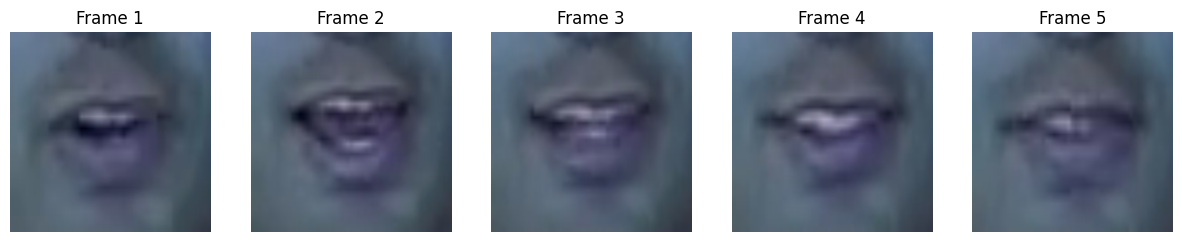


Menampilkan spectrogram audio:


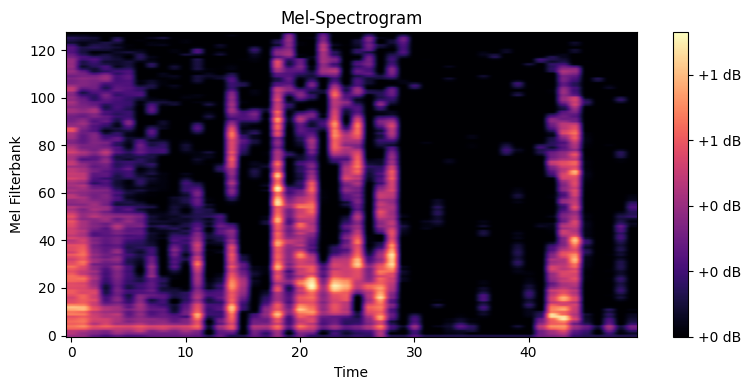

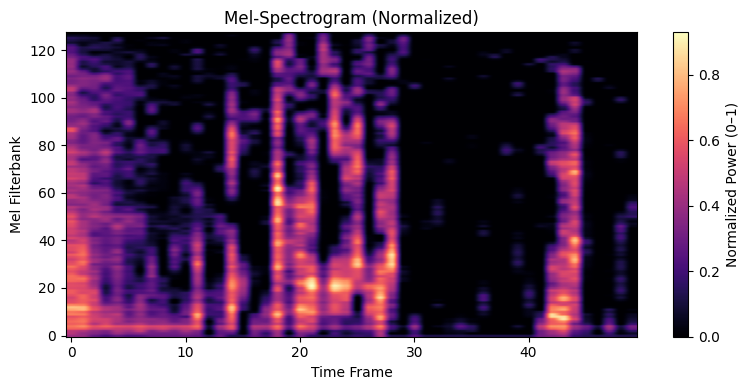

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk preview 1 sample dataset
def preview_dataset(dataset, idx=0):
    frames, audio, label = dataset[idx]

    # Tampilkan 5 frame pertama
    num_frames_to_show = min(5, frames.size(0))
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 5))
    
    for i in range(num_frames_to_show):
        img = frames[i].permute(1, 2, 0).numpy()  # (H, W, 3)
        img = (img * 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i+1}")

    plt.show()
        
    # Plot audio spectrogram
    print("\nMenampilkan spectrogram audio:")
    spectrogram = audio.squeeze(0).cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram[:, :50], aspect='auto', origin='lower', cmap='magma')
    plt.title("Mel-Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Filterbank")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()
    
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.squeeze().numpy()  # (F, T)

    # Plot hanya 50 frame pertama
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram[:, :50], aspect='auto', origin='lower', cmap='magma')
    plt.title("Mel-Spectrogram (Normalized)")
    plt.xlabel("Time Frame")
    plt.ylabel("Mel Filterbank")
    plt.colorbar(label="Normalized Power (0–1)")  # karena bukan dB
    plt.tight_layout()
    plt.show()

# Contoh pakai train_dataset
preview_dataset(train_set, idx=3)

**AlexNet-BiLSTM**

=========================================

**Coba Layer CNN**

=========================================

**Percobaan 1**

AlexNet : Bibir (5 Convolution Block + 1 BiLSTM)  + Audio (Custom 128 Filver Conv + 1 BiLSTM)

1 BiLSTM 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = x.view(B, T, -1)
        lstm_out, _ = self.lstm(x)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out
    
# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=Tr

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6967 | Train Acc: 0.4515 | Val Loss: 0.6941 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6974 | Train Acc: 0.4813 | Val Loss: 0.6950 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6925 | Train Acc: 0.5000 | Val Loss: 0.6967 | Val Acc: 0.4328
Epoch [4/40] Train Loss: 0.6815 | Train Acc: 0.5373 | Val Loss: 0.6916 | Val Acc: 0.4328
Epoch [5/40] Train Loss: 0.6621 | Train Acc: 0.6194 | Val Loss: 0.6489 | Val Acc: 0.5522
Epoch [6/40] Train Loss: 0.6044 | Train Acc: 0.7239 | Val Loss: 0.8653 | Val Acc: 0.5075
Epoch [7/40] Train Loss: 0.5856 | Train Acc: 0.7239 | Val Loss: 0.5447 | Val Acc: 0.7463
Epoch [8/40] Train Loss: 0.5590 | Train Acc: 0.7425 | Val Loss: 0.5519 | Val Acc: 0.7313
Epoch [9/40] Train Loss: 0.5378 | Train Acc: 0.7575 | Val Loss: 0.5478 | Val Acc: 0.7164
Epoch [10/40] Train Loss: 0.5272 | Train Acc: 0.7500 | Val Loss: 0.4775 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.5293 | Train Acc: 0.7687 | Val Loss: 0.4715 | Val Acc: 0.7761
Epoch [12/40] Train

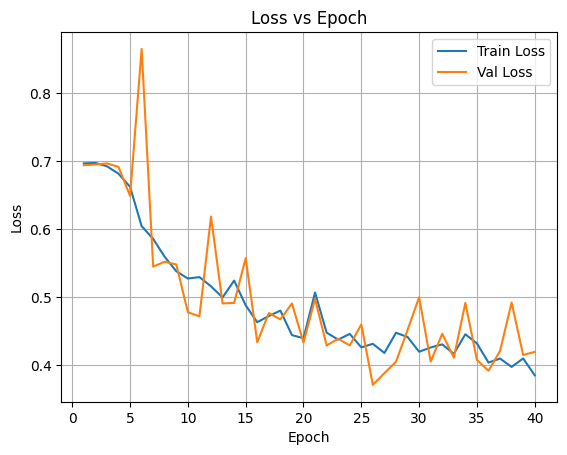

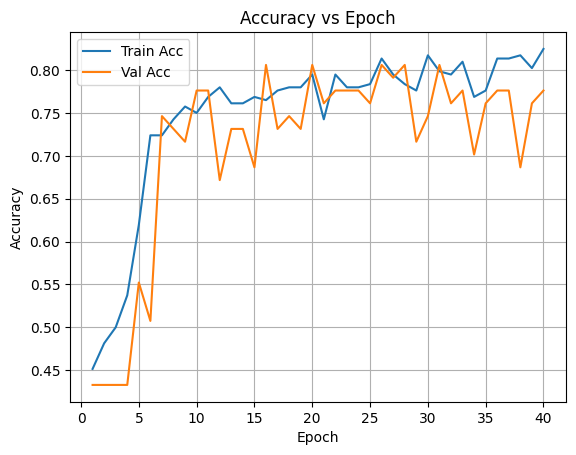

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      0.94      0.80        48
LIP-SYNC DEEPFAKE       0.91      0.59      0.72        49

         accuracy                           0.76        97
        macro avg       0.80      0.76      0.76        97
     weighted avg       0.80      0.76      0.76        97

=== CONFUSION MATRIX ===


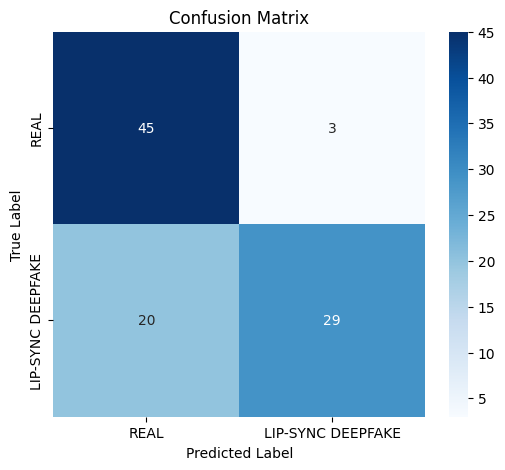

=== ROC AUC ===

📈 AUC Score: 0.8414


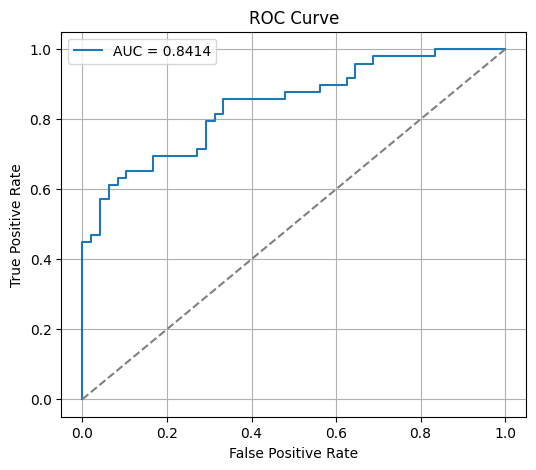

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 2**

AlexNet : Bibir (4 Convolution Block + 1 BiLSTM)  + Audio (128 Custom CNN + 1 BiLSTM)

1 BiLSTM 


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-3])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = x.view(B, T, -1) 
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [10]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/4ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6952 | Train Acc: 0.4888 | Val Loss: 0.6940 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6932 | Train Acc: 0.5299 | Val Loss: 0.6977 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6881 | Train Acc: 0.5187 | Val Loss: 0.6977 | Val Acc: 0.4328
Epoch [4/40] Train Loss: 0.6606 | Train Acc: 0.5784 | Val Loss: 0.6177 | Val Acc: 0.7313
Epoch [5/40] Train Loss: 0.5890 | Train Acc: 0.7052 | Val Loss: 0.5577 | Val Acc: 0.7463
Epoch [6/40] Train Loss: 0.5590 | Train Acc: 0.7388 | Val Loss: 0.6082 | Val Acc: 0.6567
Epoch [7/40] Train Loss: 0.5353 | Train Acc: 0.7687 | Val Loss: 0.4733 | Val Acc: 0.7761
Epoch [8/40] Train Loss: 0.5199 | Train Acc: 0.7425 | Val Loss: 0.5196 | Val Acc: 0.7313
Epoch [9/40] Train Loss: 0.4937 | Train Acc: 0.7761 | Val Loss: 0.5051 | Val Acc: 0.7612


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [10/40] Train Loss: 0.5162 | Train Acc: 0.7537 | Val Loss: 0.4999 | Val Acc: 0.7612
Epoch [11/40] Train Loss: 0.4985 | Train Acc: 0.7612 | Val Loss: 0.5302 | Val Acc: 0.6866
Epoch [12/40] Train Loss: 0.4807 | Train Acc: 0.7687 | Val Loss: 0.4389 | Val Acc: 0.8060
Epoch [13/40] Train Loss: 0.4612 | Train Acc: 0.7649 | Val Loss: 0.4042 | Val Acc: 0.8060
Epoch [14/40] Train Loss: 0.4506 | Train Acc: 0.7799 | Val Loss: 0.4021 | Val Acc: 0.8060
Epoch [15/40] Train Loss: 0.4492 | Train Acc: 0.7873 | Val Loss: 0.4236 | Val Acc: 0.7910
Epoch [16/40] Train Loss: 0.4435 | Train Acc: 0.7948 | Val Loss: 0.4355 | Val Acc: 0.7910
Epoch [17/40] Train Loss: 0.4388 | Train Acc: 0.7799 | Val Loss: 0.4358 | Val Acc: 0.8060
Epoch [18/40] Train Loss: 0.4357 | Train Acc: 0.7985 | Val Loss: 0.4011 | Val Acc: 0.7910
Epoch [19/40] Train Loss: 0.4430 | Train Acc: 0.7910 | Val Loss: 0.3897 | Val Acc: 0.7910
Epoch [20/40] Train Loss: 0.4541 | Train Acc: 0.7910 | Val Loss: 0.4233 | Val Acc: 0.7910
Epoch [21/

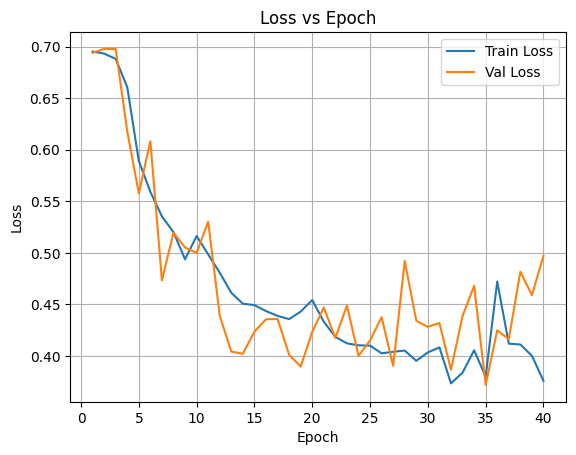

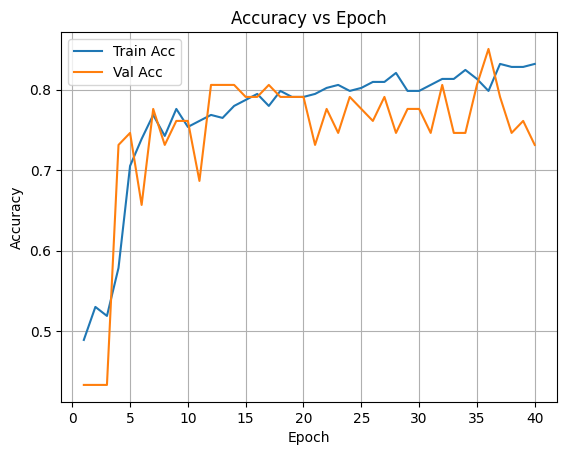

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.66      0.96      0.78        48
LIP-SYNC DEEPFAKE       0.93      0.51      0.66        49

         accuracy                           0.73        97
        macro avg       0.79      0.73      0.72        97
     weighted avg       0.79      0.73      0.72        97

=== CONFUSION MATRIX ===


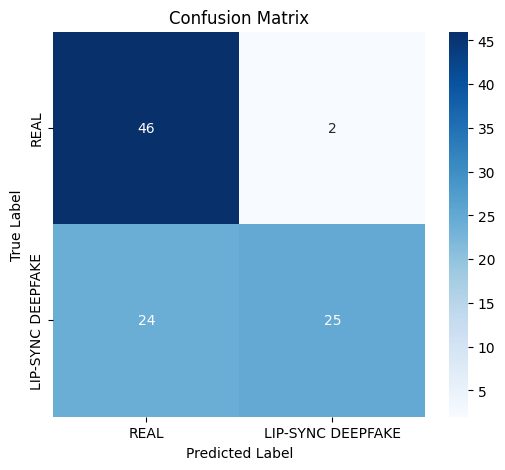

=== ROC AUC ===

📈 AUC Score: 0.8465


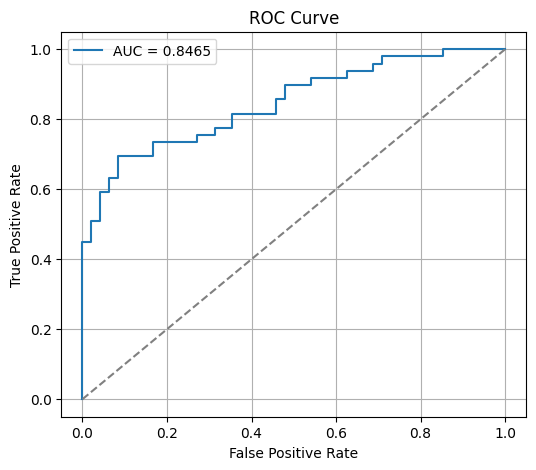

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/4ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 3**

AlexNet : Bibir (3 Convolution Block + 1 BiLSTM)  + Audio (128 Random CNN + 1 BiLSTM)

1 BiLSTM 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-5])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=384, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 128, 1, T)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [18]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(384, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): AdaptiveAvgPool2d(output_size=(1, None))
    )


In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/3ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6963 | Train Acc: 0.5261 | Val Loss: 0.6987 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6930 | Train Acc: 0.5261 | Val Loss: 0.7019 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6915 | Train Acc: 0.5261 | Val Loss: 0.7016 | Val Acc: 0.4328
Epoch [4/40] Train Loss: 0.6846 | Train Acc: 0.5261 | Val Loss: 0.6878 | Val Acc: 0.4328
Epoch [5/40] Train Loss: 0.6729 | Train Acc: 0.6194 | Val Loss: 0.6983 | Val Acc: 0.5672
Epoch [6/40] Train Loss: 0.7031 | Train Acc: 0.5000 | Val Loss: 0.6934 | Val Acc: 0.4328
Epoch [7/40] Train Loss: 0.6853 | Train Acc: 0.5634 | Val Loss: 0.6716 | Val Acc: 0.7015
Epoch [8/40] Train Loss: 0.6224 | Train Acc: 0.6978 | Val Loss: 0.5108 | Val Acc: 0.7463
Epoch [9/40] Train Loss: 0.5548 | Train Acc: 0.7313 | Val Loss: 0.5104 | Val Acc: 0.7463
Epoch [10/40] Train Loss: 0.5291 | Train Acc: 0.7724 | Val Loss: 0.4613 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.5152 | Train Acc: 0.7425 | Val Loss: 0.6360 | Val Acc: 0.6866
Epoch [12/40] Train

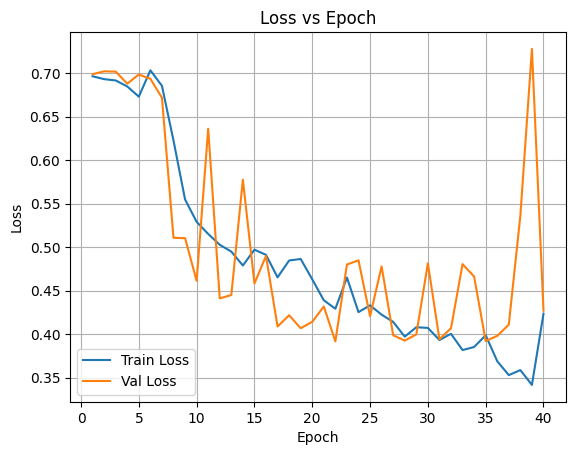

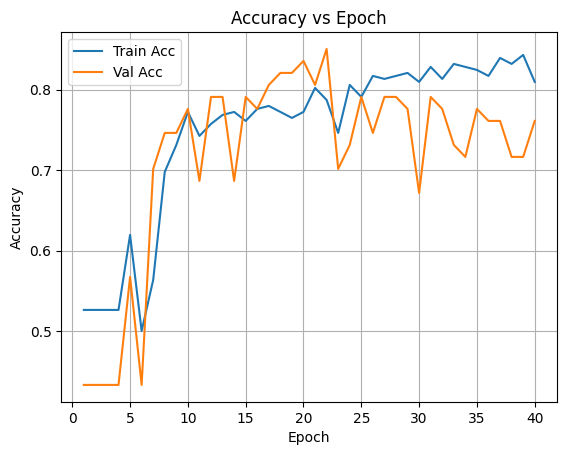

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.64      0.98      0.77        48
LIP-SYNC DEEPFAKE       0.96      0.45      0.61        49

         accuracy                           0.71        97
        macro avg       0.80      0.71      0.69        97
     weighted avg       0.80      0.71      0.69        97

=== CONFUSION MATRIX ===


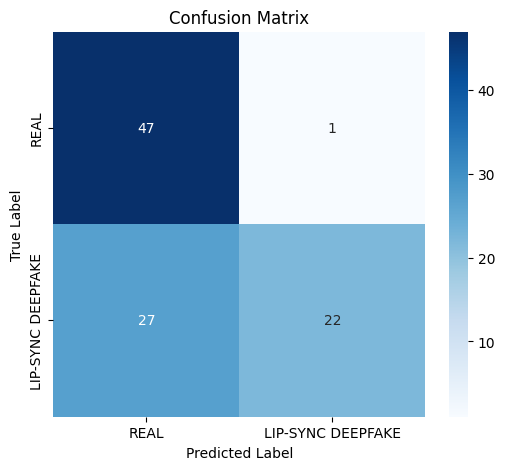

=== ROC AUC ===

📈 AUC Score: 0.7832


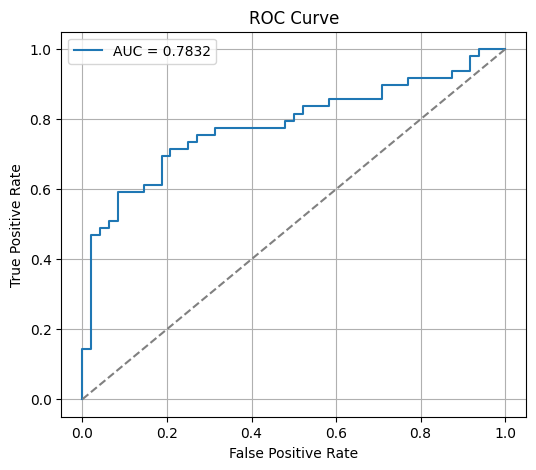

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/3ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 4**

AlexNet : Bibir (2 Convolution Block + 1 BiLSTM)  + Audio (128 Custom CNN + 1 BiLSTM)

1 BiLSTM 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-7])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=192, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 128, 1, T)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [30]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(192, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): AdaptiveAvgPool2d(output_size=(1, None))
    )
    (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (temporal_fusion): LSTM(768, 256, batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/2ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6987 | Train Acc: 0.4627 | Val Loss: 0.6943 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6935 | Train Acc: 0.5037 | Val Loss: 0.6985 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6895 | Train Acc: 0.5112 | Val Loss: 0.6878 | Val Acc: 0.5672
Epoch [4/40] Train Loss: 0.6717 | Train Acc: 0.5560 | Val Loss: 0.6559 | Val Acc: 0.6866
Epoch [5/40] Train Loss: 0.6429 | Train Acc: 0.6754 | Val Loss: 0.7003 | Val Acc: 0.5522
Epoch [6/40] Train Loss: 0.6368 | Train Acc: 0.6716 | Val Loss: 0.6447 | Val Acc: 0.6119
Epoch [7/40] Train Loss: 0.5953 | Train Acc: 0.7127 | Val Loss: 0.5894 | Val Acc: 0.6866
Epoch [8/40] Train Loss: 0.5806 | Train Acc: 0.7575 | Val Loss: 0.5588 | Val Acc: 0.7313
Epoch [9/40] Train Loss: 0.5171 | Train Acc: 0.7724 | Val Loss: 0.4829 | Val Acc: 0.7612
Epoch [10/40] Train Loss: 0.5458 | Train Acc: 0.7537 | Val Loss: 0.5420 | Val Acc: 0.6866
Epoch [11/40] Train Loss: 0.4906 | Train Acc: 0.7687 | Val Loss: 0.4511 | Val Acc: 0.8060
Epoch [12/40] Train

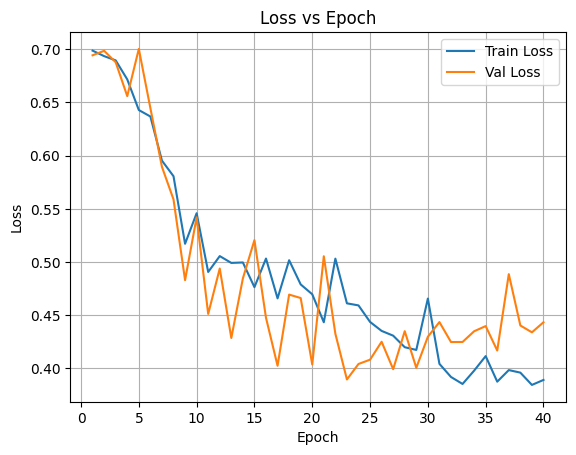

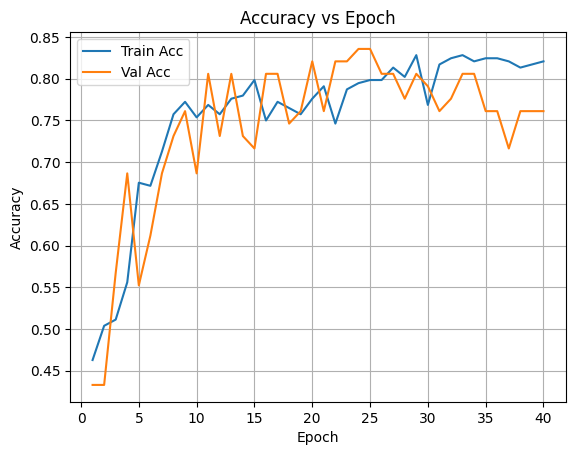

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      0.94      0.79        48
LIP-SYNC DEEPFAKE       0.90      0.57      0.70        49

         accuracy                           0.75        97
        macro avg       0.79      0.75      0.74        97
     weighted avg       0.79      0.75      0.74        97

=== CONFUSION MATRIX ===


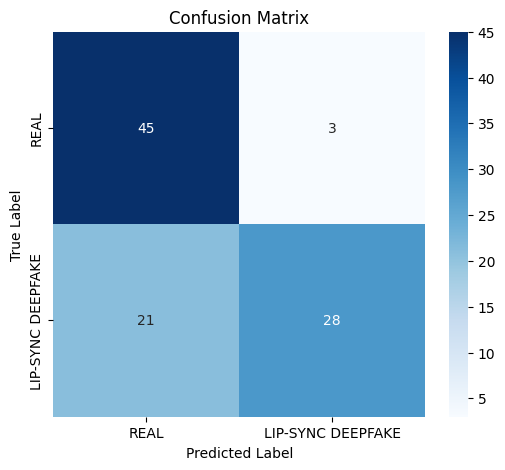

=== ROC AUC ===

📈 AUC Score: 0.7683


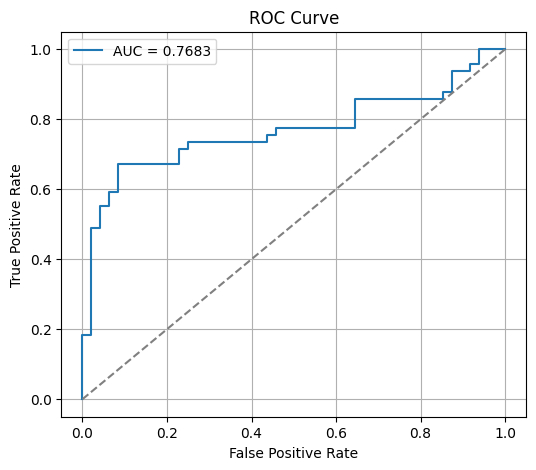

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/2ConvAlexNet-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 5**

AlexNet : Bibir (5 Convolution Block + 1 BiLSTM)  + Audio (256 Custom CNN + 1 BiLSTM)

1 BiLSTM

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [39]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/2_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6952 | Train Acc: 0.4701 | Val Loss: 0.6952 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6926 | Train Acc: 0.5224 | Val Loss: 0.6995 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6806 | Train Acc: 0.5299 | Val Loss: 0.6786 | Val Acc: 0.7313
Epoch [4/40] Train Loss: 0.6814 | Train Acc: 0.5261 | Val Loss: 0.6671 | Val Acc: 0.5224
Epoch [5/40] Train Loss: 0.6203 | Train Acc: 0.6567 | Val Loss: 0.5439 | Val Acc: 0.7463
Epoch [6/40] Train Loss: 0.5217 | Train Acc: 0.7612 | Val Loss: 0.4463 | Val Acc: 0.8209
Epoch [7/40] Train Loss: 0.5117 | Train Acc: 0.7612 | Val Loss: 0.5147 | Val Acc: 0.7313
Epoch [8/40] Train Loss: 0.5171 | Train Acc: 0.7537 | Val Loss: 0.4909 | Val Acc: 0.7612
Epoch [9/40] Train Loss: 0.4738 | Train Acc: 0.7948 | Val Loss: 0.4755 | Val Acc: 0.7910
Epoch [10/40] Train Loss: 0.4748 | Train Acc: 0.7910 | Val Loss: 0.4470 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.4672 | Train Acc: 0.7948 | Val Loss: 0.5192 | Val Acc: 0.7164
Epoch [12/40] Train

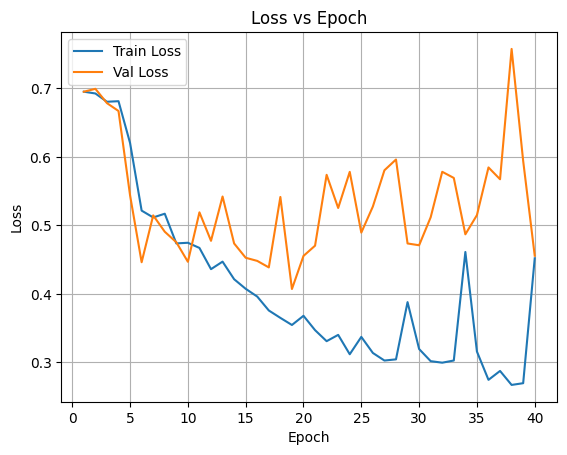

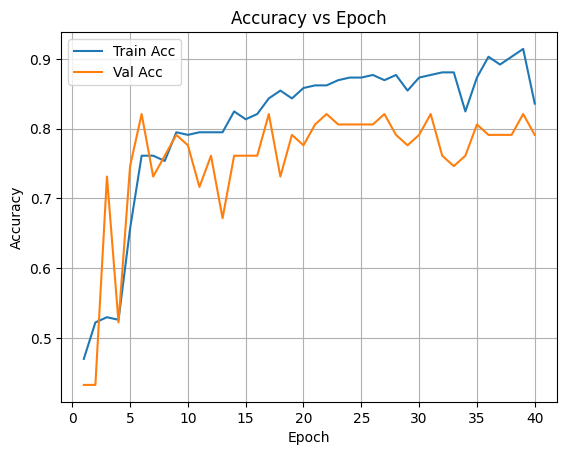

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      1.00      0.81        48
LIP-SYNC DEEPFAKE       1.00      0.53      0.69        49

         accuracy                           0.76        97
        macro avg       0.84      0.77      0.75        97
     weighted avg       0.84      0.76      0.75        97

=== CONFUSION MATRIX ===


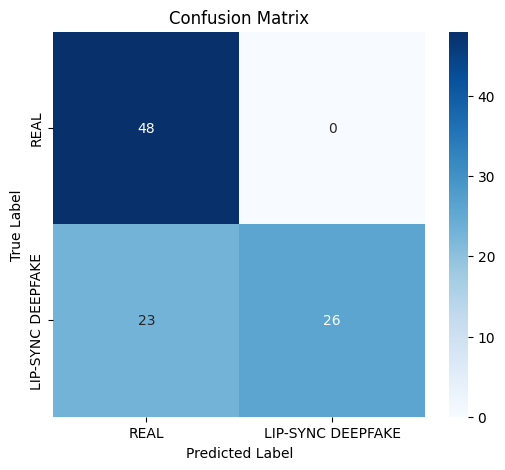

=== ROC AUC ===

📈 AUC Score: 0.8312


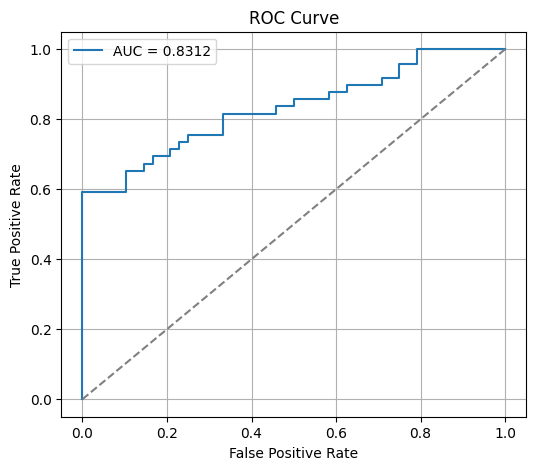

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/2_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 6**

Bibir (5 Conv Block + 1 Additional Block (512) + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

1 BiLSTM

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        original_layers = list(base.features.children())[:-1]  # buang layer terakhir (Dropout/ReLU)

        # Tambah Conv2d baru
        extra_conv = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        relu = nn.ReLU(inplace=True)

        # CNN baru dengan tambahan layer
        self.cnn = nn.Sequential(*original_layers, extra_conv, relu)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 128, 1, T)
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out
    
# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [44]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_firs

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/6_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6934 | Train Acc: 0.4925 | Val Loss: 0.6959 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6809 | Train Acc: 0.5299 | Val Loss: 0.6910 | Val Acc: 0.4478
Epoch [3/40] Train Loss: 0.6956 | Train Acc: 0.4963 | Val Loss: 0.6786 | Val Acc: 0.4925
Epoch [4/40] Train Loss: 0.6496 | Train Acc: 0.6194 | Val Loss: 0.5943 | Val Acc: 0.7463
Epoch [5/40] Train Loss: 0.5610 | Train Acc: 0.7127 | Val Loss: 0.5338 | Val Acc: 0.7015
Epoch [6/40] Train Loss: 0.4971 | Train Acc: 0.7836 | Val Loss: 0.4918 | Val Acc: 0.7761
Epoch [7/40] Train Loss: 0.4733 | Train Acc: 0.7836 | Val Loss: 0.4629 | Val Acc: 0.8060
Epoch [8/40] Train Loss: 0.4950 | Train Acc: 0.7799 | Val Loss: 0.4737 | Val Acc: 0.7761
Epoch [9/40] Train Loss: 0.4510 | Train Acc: 0.8022 | Val Loss: 0.4777 | Val Acc: 0.7612
Epoch [10/40] Train Loss: 0.4375 | Train Acc: 0.8097 | Val Loss: 0.4519 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.4455 | Train Acc: 0.8209 | Val Loss: 0.4361 | Val Acc: 0.8060
Epoch [12/40] Train

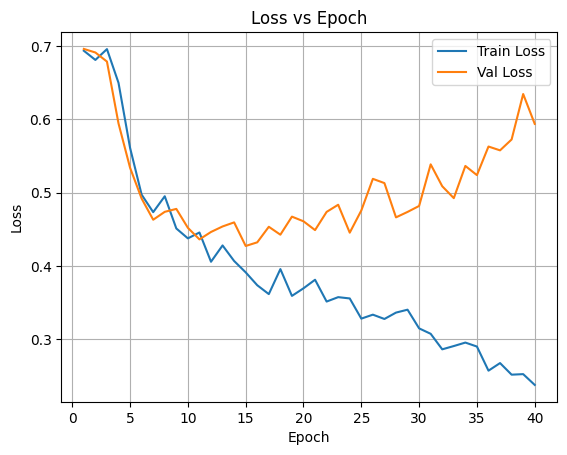

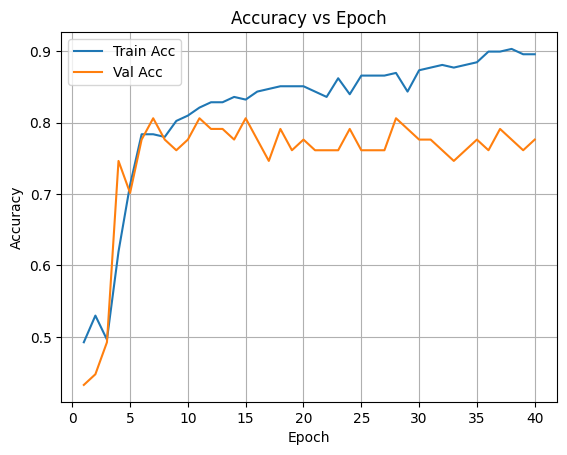

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.67      0.98      0.80        48
LIP-SYNC DEEPFAKE       0.96      0.53      0.68        49

         accuracy                           0.75        97
        macro avg       0.82      0.75      0.74        97
     weighted avg       0.82      0.75      0.74        97

=== CONFUSION MATRIX ===


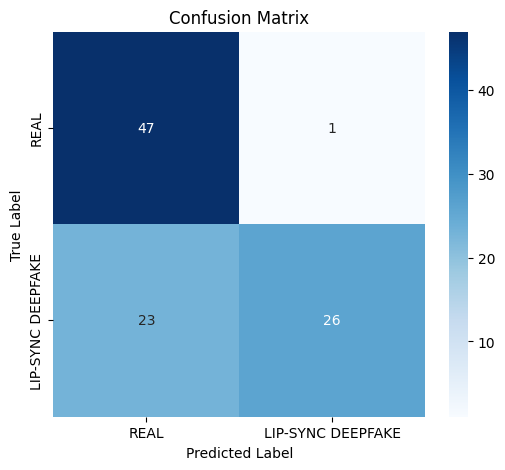

=== ROC AUC ===

📈 AUC Score: 0.8372


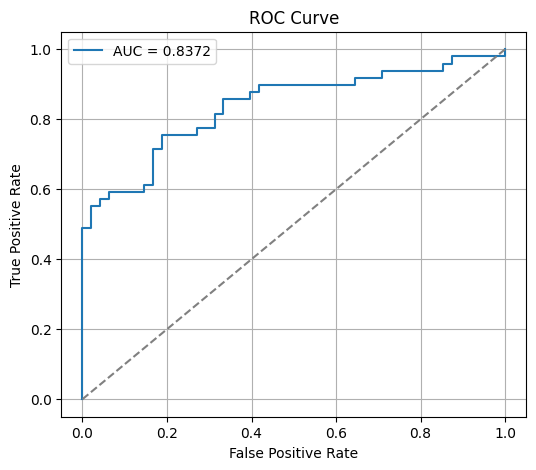

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/6_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Layer BiLSTM**

=========================================

**Percobaan 7**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out
    
# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        # Tambah Layer temporal fusion
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [16]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6938 | Train Acc: 0.5112 | Val Loss: 0.7034 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6950 | Train Acc: 0.5037 | Val Loss: 0.7001 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6566 | Train Acc: 0.5821 | Val Loss: 0.5852 | Val Acc: 0.7313
Epoch [4/40] Train Loss: 0.5761 | Train Acc: 0.7127 | Val Loss: 0.5511 | Val Acc: 0.6866
Epoch [5/40] Train Loss: 0.5092 | Train Acc: 0.7612 | Val Loss: 0.5395 | Val Acc: 0.7164
Epoch [6/40] Train Loss: 0.4965 | Train Acc: 0.7537 | Val Loss: 0.4850 | Val Acc: 0.7910
Epoch [7/40] Train Loss: 0.4689 | Train Acc: 0.7724 | Val Loss: 0.4546 | Val Acc: 0.7761
Epoch [8/40] Train Loss: 0.4468 | Train Acc: 0.8022 | Val Loss: 0.5084 | Val Acc: 0.7761
Epoch [9/40] Train Loss: 0.4339 | Train Acc: 0.8022 | Val Loss: 0.4505 | Val Acc: 0.8060
Epoch [10/40] Train Loss: 0.4327 | Train Acc: 0.8060 | Val Loss: 0.4189 | Val Acc: 0.7910
Epoch [11/40] Train Loss: 0.4114 | Train Acc: 0.8396 | Val Loss: 0.5161 | Val Acc: 0.7612
Epoch [12/40] Train

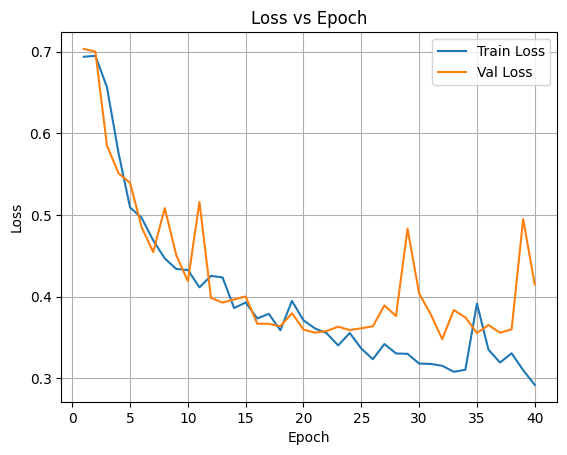

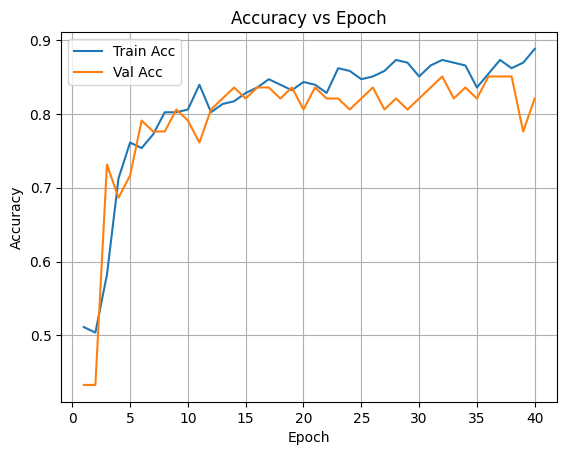

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      0.98      0.80        48
LIP-SYNC DEEPFAKE       0.96      0.55      0.70        49

         accuracy                           0.76        97
        macro avg       0.82      0.77      0.75        97
     weighted avg       0.82      0.76      0.75        97

=== CONFUSION MATRIX ===


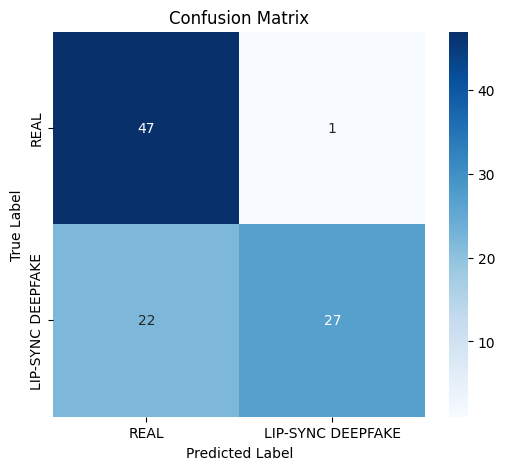

=== ROC AUC ===

📈 AUC Score: 0.8418


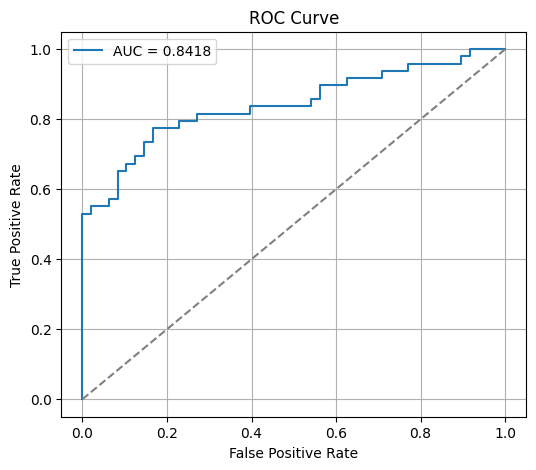

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Testing Learning Rate**

=========================================

**Percobaan 8**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-3

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
# Ganti learning rate menjadi 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-3.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7022 | Train Acc: 0.4739 | Val Loss: 0.6938 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.7025 | Train Acc: 0.4664 | Val Loss: 0.6930 | Val Acc: 0.5075
Epoch [3/40] Train Loss: 0.6962 | Train Acc: 0.4627 | Val Loss: 0.6934 | Val Acc: 0.4925
Epoch [4/40] Train Loss: 0.6964 | Train Acc: 0.4776 | Val Loss: 0.6931 | Val Acc: 0.5075
Epoch [5/40] Train Loss: 0.6933 | Train Acc: 0.5037 | Val Loss: 0.6933 | Val Acc: 0.4925
Epoch [6/40] Train Loss: 0.6931 | Train Acc: 0.5149 | Val Loss: 0.6933 | Val Acc: 0.4925
Epoch [7/40] Train Loss: 0.6934 | Train Acc: 0.5224 | Val Loss: 0.6933 | Val Acc: 0.4925
Epoch [8/40] Train Loss: 0.6935 | Train Acc: 0.5149 | Val Loss: 0.6936 | Val Acc: 0.4925
Epoch [9/40] Train Loss: 0.6807 | Train Acc: 0.5560 | Val Loss: 0.5288 | Val Acc: 0.7910
Epoch [10/40] Train Loss: 0.6775 | Train Acc: 0.5709 | Val Loss: 0.7052 | Val Acc: 0.4925
Epoch [11/40] Train Loss: 0.6946 | Train Acc: 0.4888 | Val Loss: 0.6931 | Val Acc: 0.5075
Epoch [12/40] Train

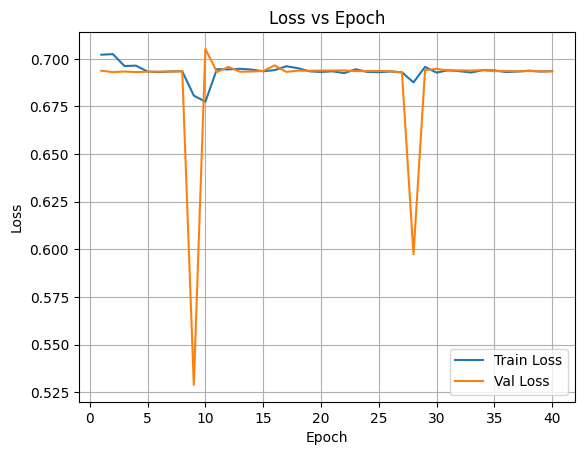

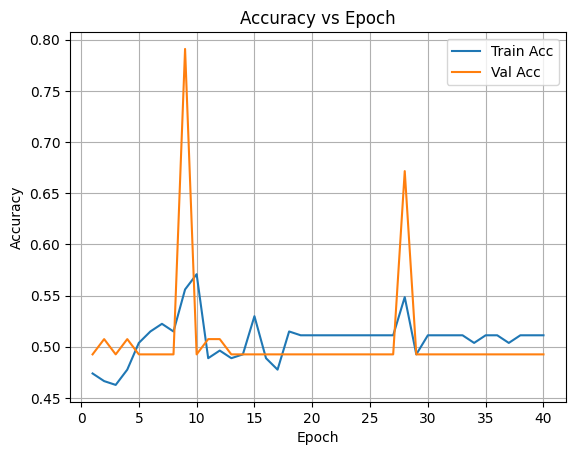

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.65      0.94      0.77        48
LIP-SYNC DEEPFAKE       0.89      0.51      0.65        49

         accuracy                           0.72        97
        macro avg       0.77      0.72      0.71        97
     weighted avg       0.77      0.72      0.71        97

=== CONFUSION MATRIX ===


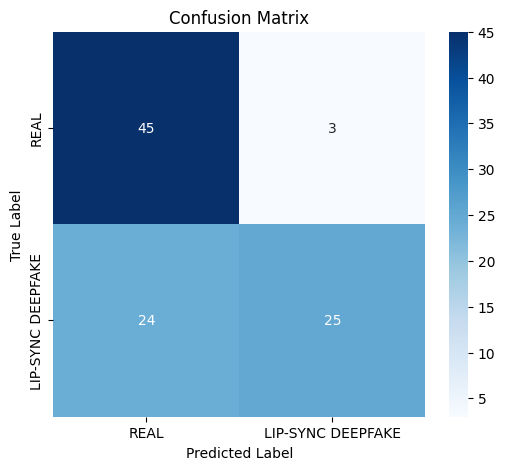

=== ROC AUC ===

📈 AUC Score: 0.6480


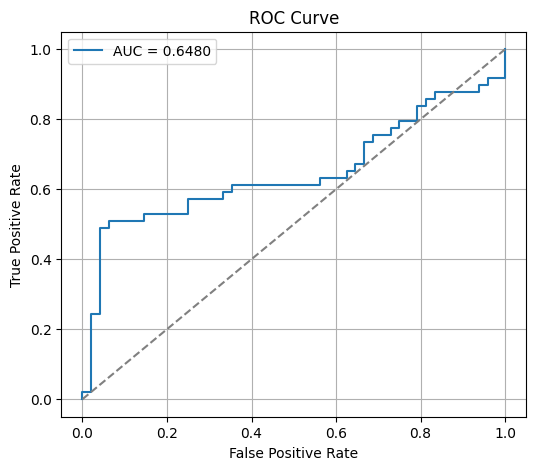

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-3.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 9**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-5

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out
    
# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out
    
# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [ ]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
# Ganti learning rate menjadi 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-5.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6938 | Train Acc: 0.4739 | Val Loss: 0.6930 | Val Acc: 0.5075
Epoch [2/40] Train Loss: 0.6938 | Train Acc: 0.4440 | Val Loss: 0.6929 | Val Acc: 0.5075
Epoch [3/40] Train Loss: 0.6926 | Train Acc: 0.5336 | Val Loss: 0.6928 | Val Acc: 0.4925
Epoch [4/40] Train Loss: 0.6929 | Train Acc: 0.5037 | Val Loss: 0.6924 | Val Acc: 0.4925
Epoch [5/40] Train Loss: 0.6927 | Train Acc: 0.5448 | Val Loss: 0.6918 | Val Acc: 0.5224
Epoch [6/40] Train Loss: 0.6913 | Train Acc: 0.5373 | Val Loss: 0.6904 | Val Acc: 0.4925
Epoch [7/40] Train Loss: 0.6890 | Train Acc: 0.5336 | Val Loss: 0.6871 | Val Acc: 0.4925
Epoch [8/40] Train Loss: 0.6851 | Train Acc: 0.5187 | Val Loss: 0.6802 | Val Acc: 0.4925
Epoch [9/40] Train Loss: 0.6731 | Train Acc: 0.5149 | Val Loss: 0.6609 | Val Acc: 0.5821
Epoch [10/40] Train Loss: 0.6418 | Train Acc: 0.6455 | Val Loss: 0.6145 | Val Acc: 0.7164
Epoch [11/40] Train Loss: 0.5947 | Train Acc: 0.7164 | Val Loss: 0.5695 | Val Acc: 0.7164
Epoch [12/40] Train

In [19]:
print(best_val_loss)

0.46684760077675774


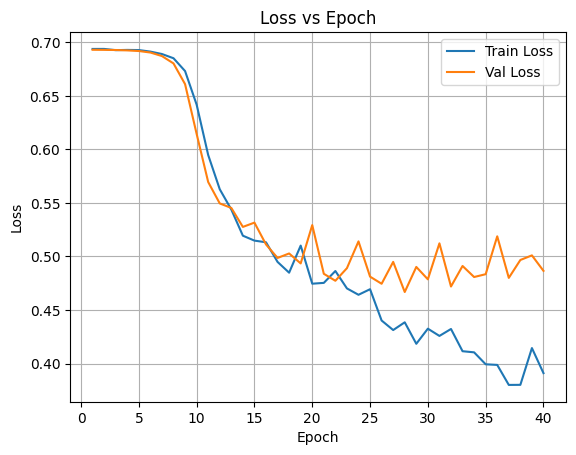

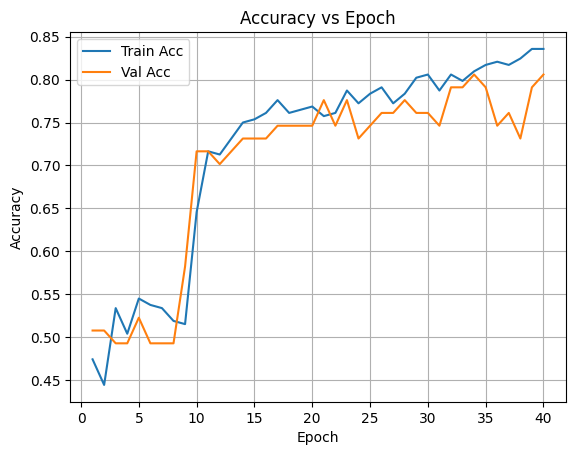

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

**Percobaan 10**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-2

In [4]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-2.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.9331 | Train Acc: 0.5224 | Val Loss: 0.7113 | Val Acc: 0.4627
Epoch [2/40] Train Loss: 0.7014 | Train Acc: 0.4739 | Val Loss: 0.6966 | Val Acc: 0.4627
Epoch [3/40] Train Loss: 0.6944 | Train Acc: 0.5187 | Val Loss: 0.6973 | Val Acc: 0.4627
Epoch [4/40] Train Loss: 0.6933 | Train Acc: 0.5187 | Val Loss: 0.6950 | Val Acc: 0.4627
Epoch [5/40] Train Loss: 0.6936 | Train Acc: 0.5187 | Val Loss: 0.6957 | Val Acc: 0.4627
Epoch [6/40] Train Loss: 0.6931 | Train Acc: 0.5187 | Val Loss: 0.6952 | Val Acc: 0.4627
Epoch [7/40] Train Loss: 0.6940 | Train Acc: 0.5187 | Val Loss: 0.6998 | Val Acc: 0.4627
Epoch [8/40] Train Loss: 0.6937 | Train Acc: 0.5187 | Val Loss: 0.6945 | Val Acc: 0.4627
Epoch [9/40] Train Loss: 0.6939 | Train Acc: 0.5187 | Val Loss: 0.6963 | Val Acc: 0.4627
Epoch [10/40] Train Loss: 0.6941 | Train Acc: 0.5037 | Val Loss: 0.6942 | Val Acc: 0.4627
Epoch [11/40] Train Loss: 0.6934 | Train Acc: 0.5187 | Val Loss: 0.6977 | Val Acc: 0.4627
Epoch [12/40] Train

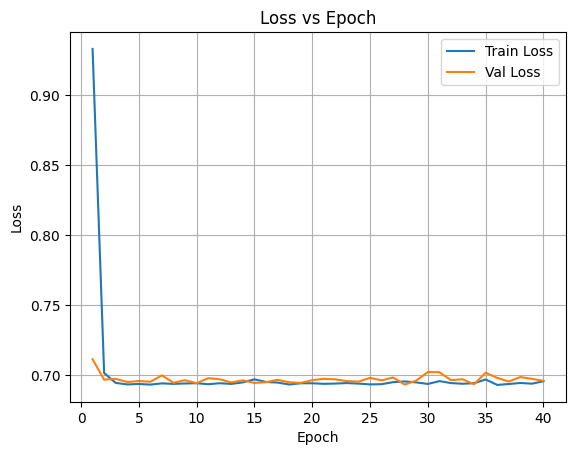

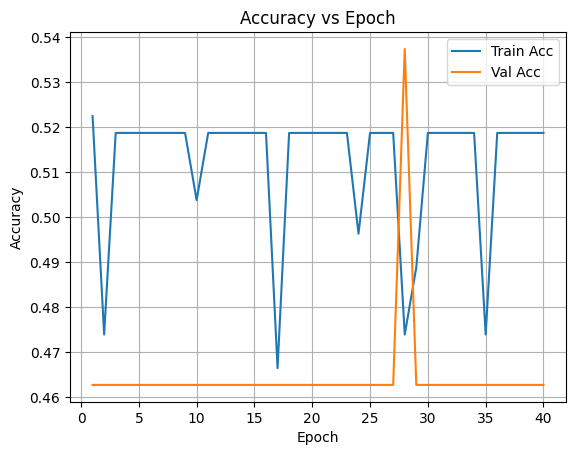

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.00      0.00      0.00        48
LIP-SYNC DEEPFAKE       0.51      1.00      0.67        49

         accuracy                           0.51        97
        macro avg       0.25      0.50      0.34        97
     weighted avg       0.26      0.51      0.34        97

=== CONFUSION MATRIX ===


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

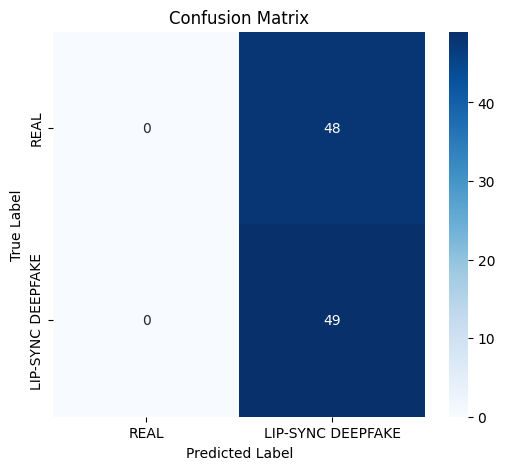

=== ROC AUC ===

📈 AUC Score: 0.5000


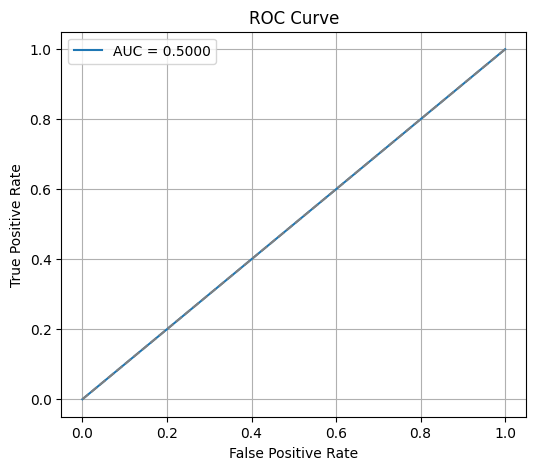

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-2.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 11**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-1.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 7.4106 | Train Acc: 0.5075 | Val Loss: 0.6915 | Val Acc: 0.5373
Epoch [2/40] Train Loss: 0.7014 | Train Acc: 0.5187 | Val Loss: 0.6957 | Val Acc: 0.5373
Epoch [3/40] Train Loss: 0.7141 | Train Acc: 0.4963 | Val Loss: 0.7141 | Val Acc: 0.4627
Epoch [4/40] Train Loss: 0.6961 | Train Acc: 0.5485 | Val Loss: 0.7040 | Val Acc: 0.5373
Epoch [5/40] Train Loss: 0.7120 | Train Acc: 0.4813 | Val Loss: 0.7281 | Val Acc: 0.4627
Epoch [6/40] Train Loss: 0.6947 | Train Acc: 0.5336 | Val Loss: 0.7761 | Val Acc: 0.4627
Epoch [7/40] Train Loss: 0.7011 | Train Acc: 0.5261 | Val Loss: 0.7008 | Val Acc: 0.4627
Epoch [8/40] Train Loss: 0.7088 | Train Acc: 0.4888 | Val Loss: 0.7126 | Val Acc: 0.4627
Epoch [9/40] Train Loss: 0.7026 | Train Acc: 0.4963 | Val Loss: 0.6904 | Val Acc: 0.5373
Epoch [10/40] Train Loss: 0.7042 | Train Acc: 0.5187 | Val Loss: 0.6912 | Val Acc: 0.5373
Epoch [11/40] Train Loss: 0.7063 | Train Acc: 0.4590 | Val Loss: 0.6972 | Val Acc: 0.4627
Epoch [12/40] Train

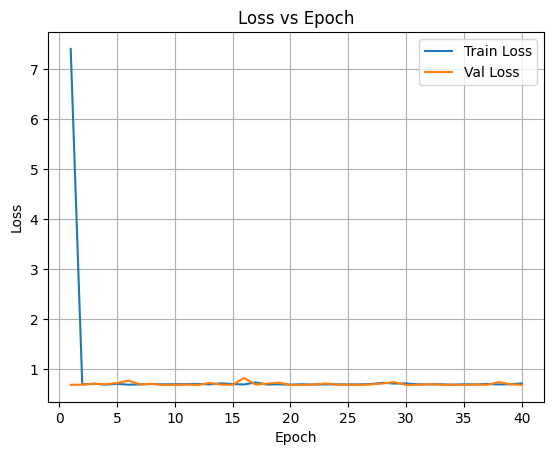

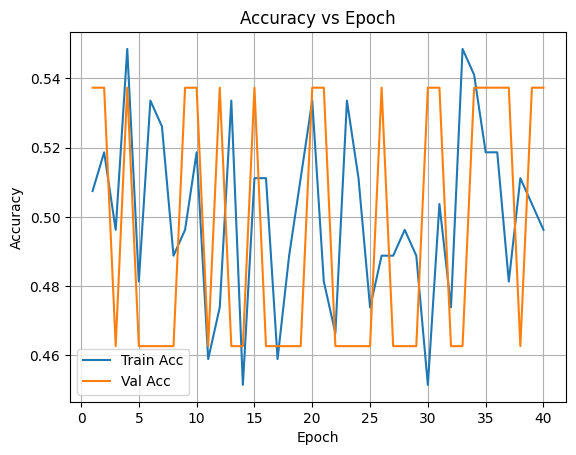

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.00      0.00      0.00        48
LIP-SYNC DEEPFAKE       0.51      1.00      0.67        49

         accuracy                           0.51        97
        macro avg       0.25      0.50      0.34        97
     weighted avg       0.26      0.51      0.34        97

=== CONFUSION MATRIX ===


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

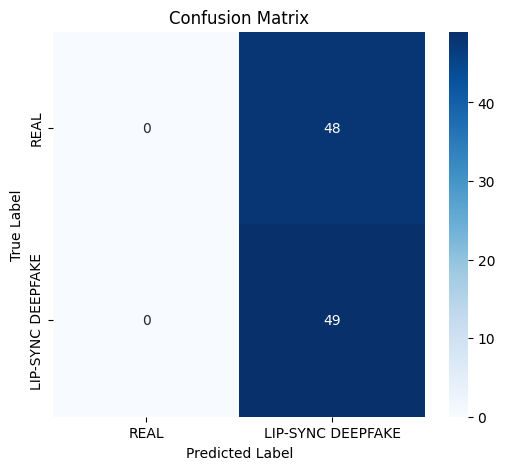

=== ROC AUC ===

📈 AUC Score: 0.5000


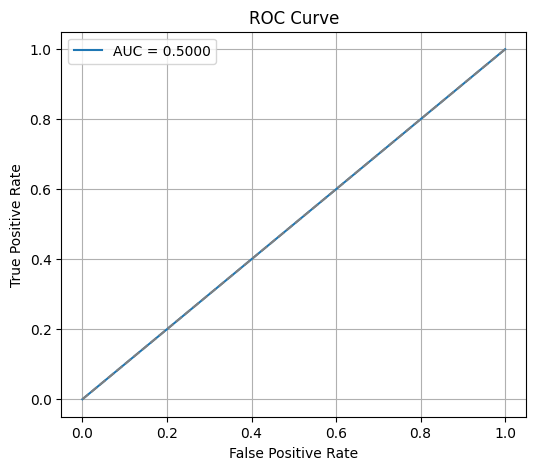

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_LR1e-1.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Freeze Layer CNN**

=========================================

**Percobaan 12**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-4

Half Freeze AlexNet

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
       # Freeze sebagian layer
        # Freeze semua feature extractor, tapi buka beberapa conv terakhir
        for idx, layer in enumerate(base.features.children()):
            if idx <= 5:  # layer 0-5 freeze
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters():
                    param.requires_grad = True
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [28]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_HalfFreeze.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6939 | Train Acc: 0.5112 | Val Loss: 0.6938 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.6971 | Train Acc: 0.5037 | Val Loss: 0.6930 | Val Acc: 0.6418
Epoch [3/40] Train Loss: 0.6936 | Train Acc: 0.4888 | Val Loss: 0.6907 | Val Acc: 0.5522
Epoch [4/40] Train Loss: 0.6594 | Train Acc: 0.5970 | Val Loss: 0.5227 | Val Acc: 0.7761
Epoch [5/40] Train Loss: 0.5725 | Train Acc: 0.7463 | Val Loss: 0.5334 | Val Acc: 0.7761
Epoch [6/40] Train Loss: 0.5346 | Train Acc: 0.7537 | Val Loss: 0.4625 | Val Acc: 0.8060
Epoch [7/40] Train Loss: 0.5278 | Train Acc: 0.7463 | Val Loss: 0.4419 | Val Acc: 0.8507
Epoch [8/40] Train Loss: 0.4968 | Train Acc: 0.7836 | Val Loss: 0.4493 | Val Acc: 0.8060
Epoch [9/40] Train Loss: 0.4986 | Train Acc: 0.7724 | Val Loss: 0.4466 | Val Acc: 0.7761
Epoch [10/40] Train Loss: 0.4871 | Train Acc: 0.7799 | Val Loss: 0.4472 | Val Acc: 0.8209
Epoch [11/40] Train Loss: 0.4865 | Train Acc: 0.7910 | Val Loss: 0.4786 | Val Acc: 0.7761
Epoch [12/40] Train

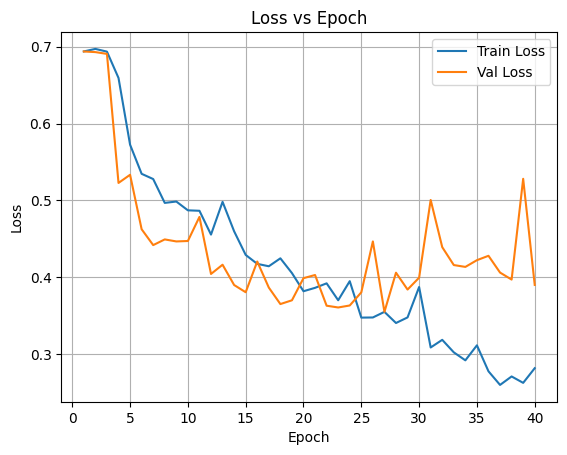

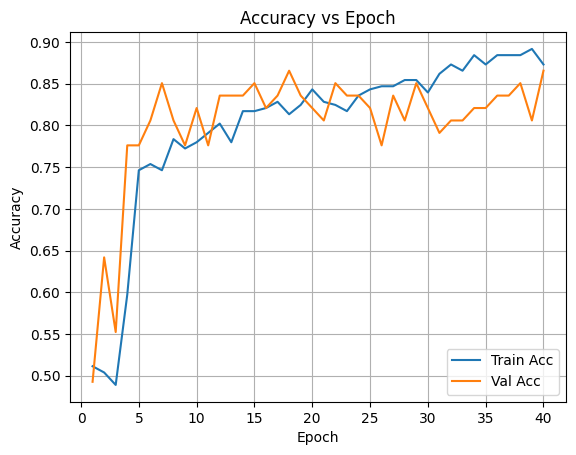

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.67      0.96      0.79        48
LIP-SYNC DEEPFAKE       0.93      0.53      0.68        49

         accuracy                           0.74        97
        macro avg       0.80      0.74      0.73        97
     weighted avg       0.80      0.74      0.73        97

=== CONFUSION MATRIX ===


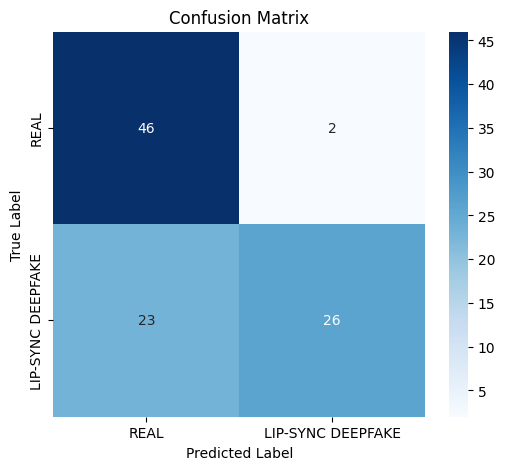

=== ROC AUC ===

📈 AUC Score: 0.8363


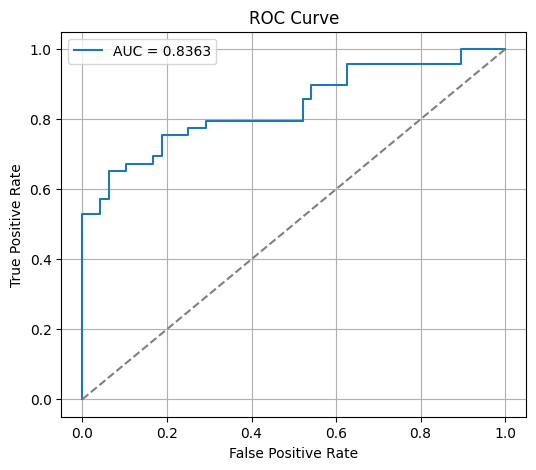

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_HalfFreeze.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 13**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-4

Full Freeze AlexNet

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=True)
        # Freeze semua feature extractor, tapi buka beberapa conv terakhir
        for idx, layer in enumerate(base.features.children()):
            for param in layer.parameters():
                    param.requires_grad = False
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [38]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_FullFreeze.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6955 | Train Acc: 0.5112 | Val Loss: 0.6941 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.6935 | Train Acc: 0.5112 | Val Loss: 0.6923 | Val Acc: 0.4925
Epoch [3/40] Train Loss: 0.6792 | Train Acc: 0.5410 | Val Loss: 0.6310 | Val Acc: 0.7015
Epoch [4/40] Train Loss: 0.5820 | Train Acc: 0.7239 | Val Loss: 0.4762 | Val Acc: 0.7910
Epoch [5/40] Train Loss: 0.5156 | Train Acc: 0.7351 | Val Loss: 0.4488 | Val Acc: 0.8209
Epoch [6/40] Train Loss: 0.4929 | Train Acc: 0.7799 | Val Loss: 0.5150 | Val Acc: 0.7463
Epoch [7/40] Train Loss: 0.5184 | Train Acc: 0.7313 | Val Loss: 0.4836 | Val Acc: 0.7612
Epoch [8/40] Train Loss: 0.4636 | Train Acc: 0.7836 | Val Loss: 0.4319 | Val Acc: 0.8060
Epoch [9/40] Train Loss: 0.4571 | Train Acc: 0.7724 | Val Loss: 0.4385 | Val Acc: 0.7761
Epoch [10/40] Train Loss: 0.4482 | Train Acc: 0.7799 | Val Loss: 0.4106 | Val Acc: 0.8358
Epoch [11/40] Train Loss: 0.4409 | Train Acc: 0.7761 | Val Loss: 0.4264 | Val Acc: 0.8060
Epoch [12/40] Train

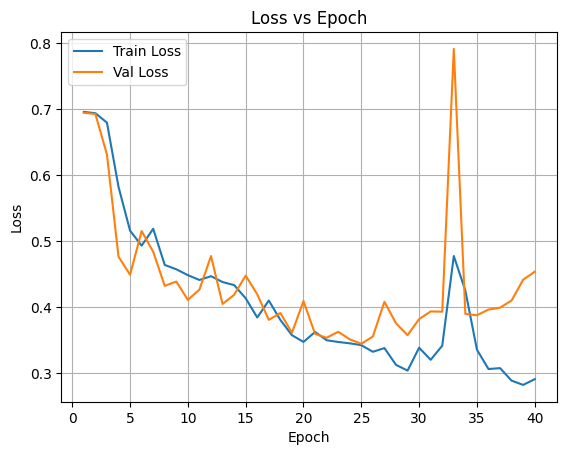

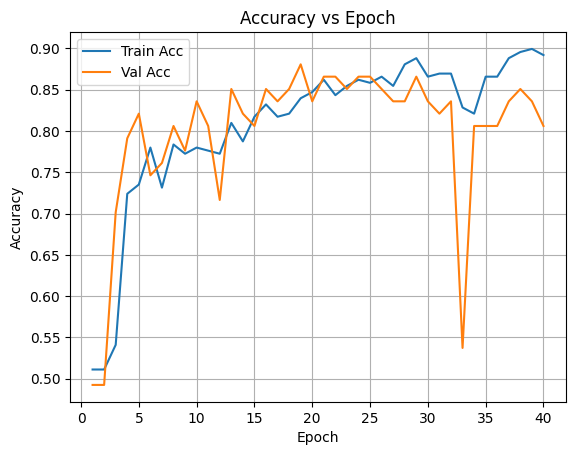

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      0.98      0.80        48
LIP-SYNC DEEPFAKE       0.96      0.55      0.70        49

         accuracy                           0.76        97
        macro avg       0.82      0.77      0.75        97
     weighted avg       0.82      0.76      0.75        97

=== CONFUSION MATRIX ===


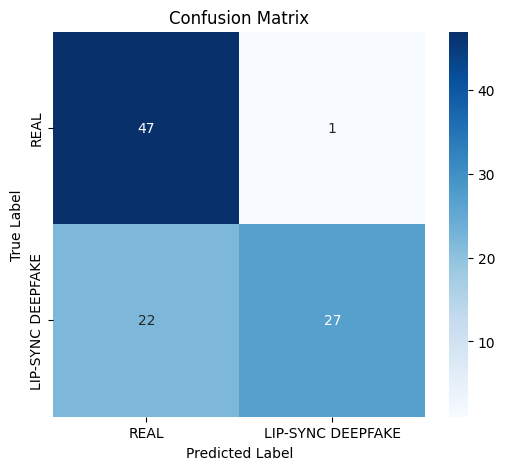

=== ROC AUC ===

📈 AUC Score: 0.8644


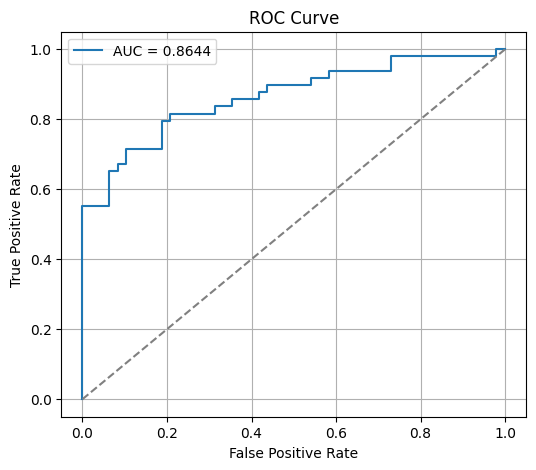

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_FullFreeze.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Data Bukan Pretrain**

=========================================

**Percobaan 14**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-4

Not Pretrained

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [11]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6941 | Train Acc: 0.5187 | Val Loss: 0.6934 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.6935 | Train Acc: 0.4813 | Val Loss: 0.6892 | Val Acc: 0.4925
Epoch [3/40] Train Loss: 0.6519 | Train Acc: 0.6119 | Val Loss: 0.6644 | Val Acc: 0.6866
Epoch [4/40] Train Loss: 0.5485 | Train Acc: 0.7239 | Val Loss: 0.5440 | Val Acc: 0.6866
Epoch [5/40] Train Loss: 0.4590 | Train Acc: 0.7948 | Val Loss: 0.5690 | Val Acc: 0.7313
Epoch [6/40] Train Loss: 0.4801 | Train Acc: 0.7799 | Val Loss: 0.5667 | Val Acc: 0.7313
Epoch [7/40] Train Loss: 0.4584 | Train Acc: 0.8022 | Val Loss: 0.5600 | Val Acc: 0.7313
Epoch [8/40] Train Loss: 0.4528 | Train Acc: 0.7948 | Val Loss: 0.5466 | Val Acc: 0.7015
Epoch [9/40] Train Loss: 0.4695 | Train Acc: 0.7836 | Val Loss: 0.5484 | Val Acc: 0.7313
Epoch [10/40] Train Loss: 0.4385 | Train Acc: 0.8097 | Val Loss: 0.5717 | Val Acc: 0.7463
Epoch [11/40] Train Loss: 0.4780 | Train Acc: 0.8060 | Val Loss: 0.5371 | Val Acc: 0.7164
Epoch [12/40] Train

In [13]:
print(best_val_loss)

0.4127777258851635


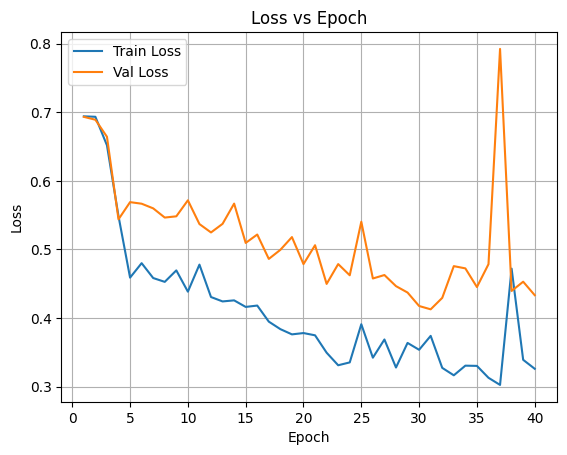

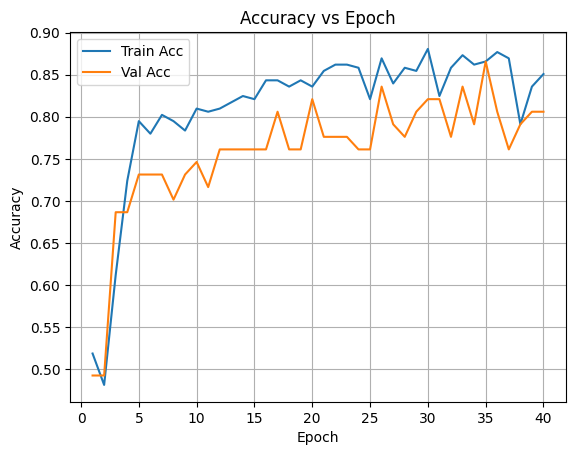

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      1.00      0.81        48
LIP-SYNC DEEPFAKE       1.00      0.55      0.71        49

         accuracy                           0.77        97
        macro avg       0.84      0.78      0.76        97
     weighted avg       0.84      0.77      0.76        97

=== CONFUSION MATRIX ===


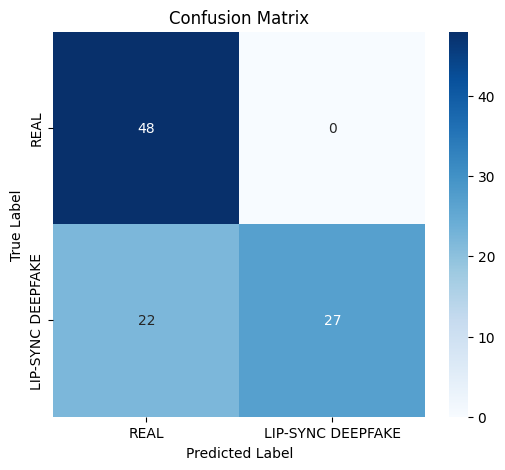

=== ROC AUC ===

📈 AUC Score: 0.8461


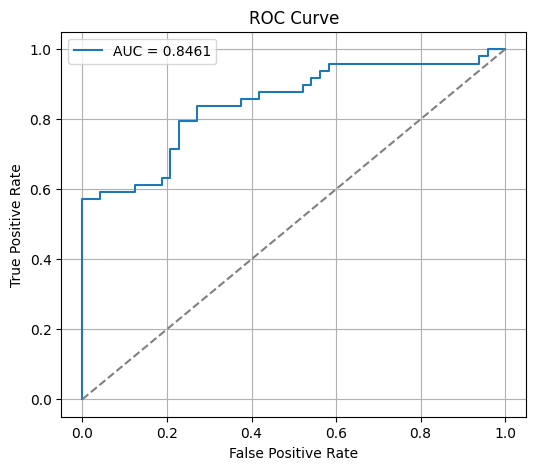

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 15**

Bibir (5 Conv Block + 1 Additional Block (512) + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

1 BiLSTM

Not Pretrained

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        for param in base.parameters():
                param.requires_grad = True
        original_layers = list(base.features.children())[:-1]  # buang layer terakhir (Dropout/ReLU)
        # Buat CNN baru dengan tambahan layer
        self.cnn = nn.Sequential(*original_layers)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [54]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM_notPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6927 | Train Acc: 0.5261 | Val Loss: 0.6975 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6859 | Train Acc: 0.5336 | Val Loss: 0.6871 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6509 | Train Acc: 0.6455 | Val Loss: 0.5979 | Val Acc: 0.6418
Epoch [4/40] Train Loss: 0.5873 | Train Acc: 0.7015 | Val Loss: 0.4598 | Val Acc: 0.8060
Epoch [5/40] Train Loss: 0.5365 | Train Acc: 0.7500 | Val Loss: 0.7077 | Val Acc: 0.6567
Epoch [6/40] Train Loss: 0.5288 | Train Acc: 0.7649 | Val Loss: 0.4640 | Val Acc: 0.8060
Epoch [7/40] Train Loss: 0.4779 | Train Acc: 0.7799 | Val Loss: 0.4416 | Val Acc: 0.8060
Epoch [8/40] Train Loss: 0.4747 | Train Acc: 0.7575 | Val Loss: 0.4314 | Val Acc: 0.8060
Epoch [9/40] Train Loss: 0.4508 | Train Acc: 0.8097 | Val Loss: 0.4362 | Val Acc: 0.8209
Epoch [10/40] Train Loss: 0.4279 | Train Acc: 0.8172 | Val Loss: 0.4937 | Val Acc: 0.7612
Epoch [11/40] Train Loss: 0.4587 | Train Acc: 0.7985 | Val Loss: 0.4485 | Val Acc: 0.7910
Epoch [12/40] Train

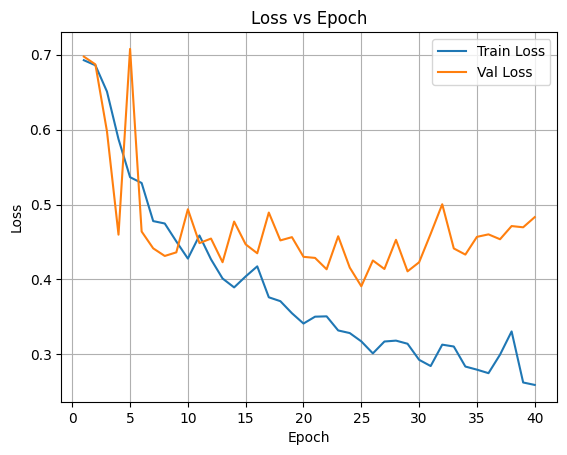

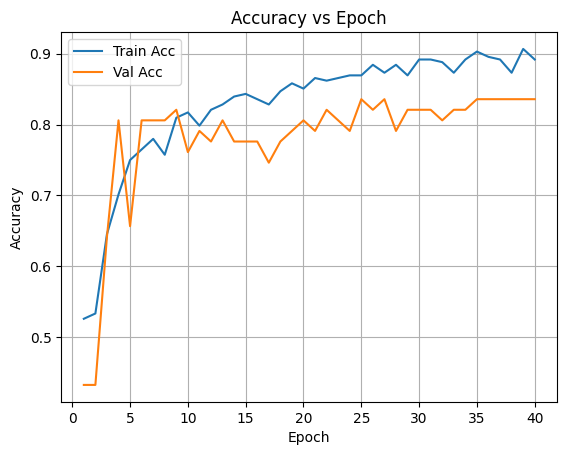

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      0.96      0.80        48
LIP-SYNC DEEPFAKE       0.93      0.57      0.71        49

         accuracy                           0.76        97
        macro avg       0.81      0.76      0.75        97
     weighted avg       0.81      0.76      0.75        97

=== CONFUSION MATRIX ===


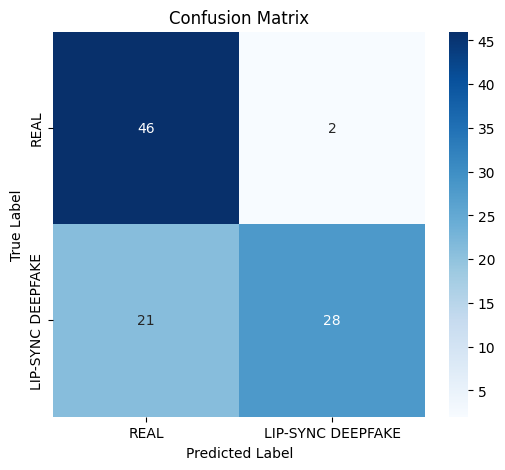

=== ROC AUC ===

📈 AUC Score: 0.8525


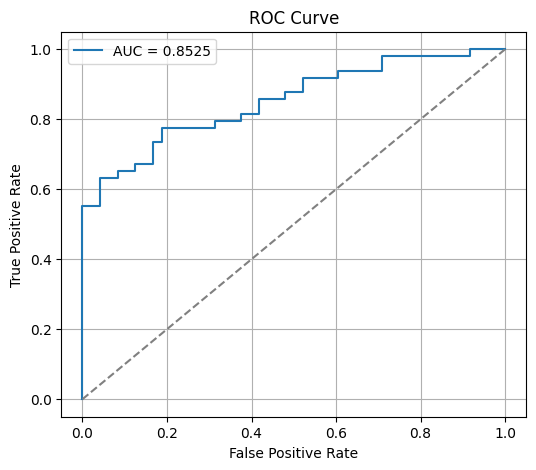

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_BiLSTM_notPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Modifikasi CNN Audio**

=========================================

**Percobaan 16**

**Coba Dobel Layer Audio**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 64, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 256, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-DoubleLayer_2-BiLSTM_NotPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6942 | Train Acc: 0.4366 | Val Loss: 0.6940 | Val Acc: 0.4478
Epoch [2/40] Train Loss: 0.6940 | Train Acc: 0.5000 | Val Loss: 0.6939 | Val Acc: 0.4478
Epoch [3/40] Train Loss: 0.6887 | Train Acc: 0.5634 | Val Loss: 0.6510 | Val Acc: 0.5522
Epoch [4/40] Train Loss: 0.5997 | Train Acc: 0.6828 | Val Loss: 0.4770 | Val Acc: 0.8060
Epoch [5/40] Train Loss: 0.4930 | Train Acc: 0.7910 | Val Loss: 0.4306 | Val Acc: 0.8358
Epoch [6/40] Train Loss: 0.4695 | Train Acc: 0.7948 | Val Loss: 0.4358 | Val Acc: 0.8060
Epoch [7/40] Train Loss: 0.4415 | Train Acc: 0.8060 | Val Loss: 0.4595 | Val Acc: 0.7761
Epoch [8/40] Train Loss: 0.4442 | Train Acc: 0.8060 | Val Loss: 0.4089 | Val Acc: 0.8358
Epoch [9/40] Train Loss: 0.4393 | Train Acc: 0.7799 | Val Loss: 0.3964 | Val Acc: 0.8358
Epoch [10/40] Train Loss: 0.4376 | Train Acc: 0.7948 | Val Loss: 0.4235 | Val Acc: 0.8358
Epoch [11/40] Train Loss: 0.3893 | Train Acc: 0.8470 | Val Loss: 0.5596 | Val Acc: 0.7164
Epoch [12/40] Train

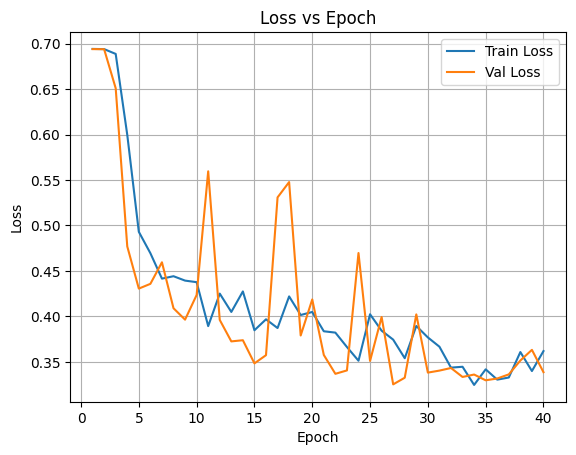

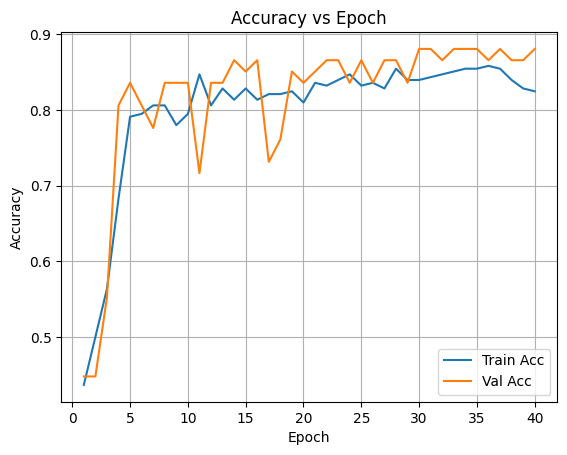

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      1.00      0.81        48
LIP-SYNC DEEPFAKE       1.00      0.55      0.71        49

         accuracy                           0.77        97
        macro avg       0.84      0.78      0.76        97
     weighted avg       0.84      0.77      0.76        97

=== CONFUSION MATRIX ===


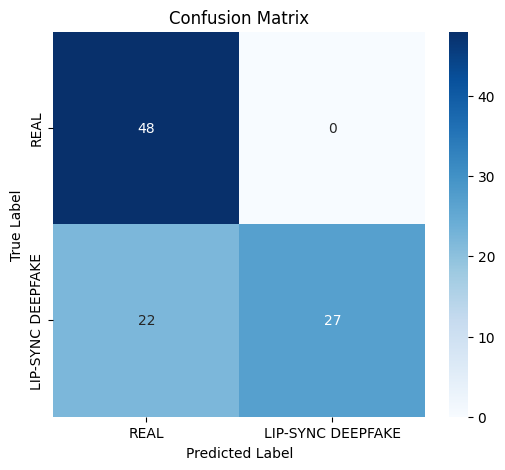

=== ROC AUC ===

📈 AUC Score: 0.8389


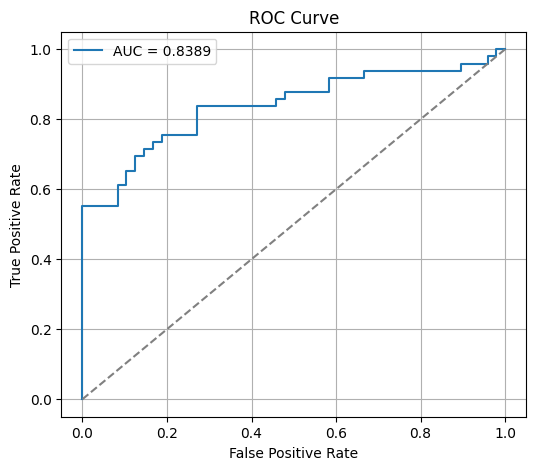

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-DoubleLayer_2-BiLSTM_NotPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Toleransi Delay Melalui Kernel Audio**

=========================================

**Percobaan 17**

**coba kernel 5x5 pada conv (1,64)**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Perbesar kernel menjadi 5x5
            nn.Conv2d(1, 64, kernel_size=(5, 5), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [19]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel5x5_2-BiLSTM_NotPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6951 | Train Acc: 0.4963 | Val Loss: 0.6885 | Val Acc: 0.5522
Epoch [2/40] Train Loss: 0.6877 | Train Acc: 0.5597 | Val Loss: 0.6581 | Val Acc: 0.6567
Epoch [3/40] Train Loss: 0.5540 | Train Acc: 0.7724 | Val Loss: 0.4763 | Val Acc: 0.7761
Epoch [4/40] Train Loss: 0.5172 | Train Acc: 0.7687 | Val Loss: 0.5010 | Val Acc: 0.7612
Epoch [5/40] Train Loss: 0.5095 | Train Acc: 0.7575 | Val Loss: 0.4621 | Val Acc: 0.7761
Epoch [6/40] Train Loss: 0.4768 | Train Acc: 0.7985 | Val Loss: 0.4542 | Val Acc: 0.7910
Epoch [7/40] Train Loss: 0.4876 | Train Acc: 0.7836 | Val Loss: 0.5068 | Val Acc: 0.7612
Epoch [8/40] Train Loss: 0.4885 | Train Acc: 0.7799 | Val Loss: 0.4693 | Val Acc: 0.7761
Epoch [9/40] Train Loss: 0.4736 | Train Acc: 0.7910 | Val Loss: 0.4646 | Val Acc: 0.7910
Epoch [10/40] Train Loss: 0.4526 | Train Acc: 0.7873 | Val Loss: 0.4265 | Val Acc: 0.8209
Epoch [11/40] Train Loss: 0.4498 | Train Acc: 0.7910 | Val Loss: 0.4214 | Val Acc: 0.8507
Epoch [12/40] Train

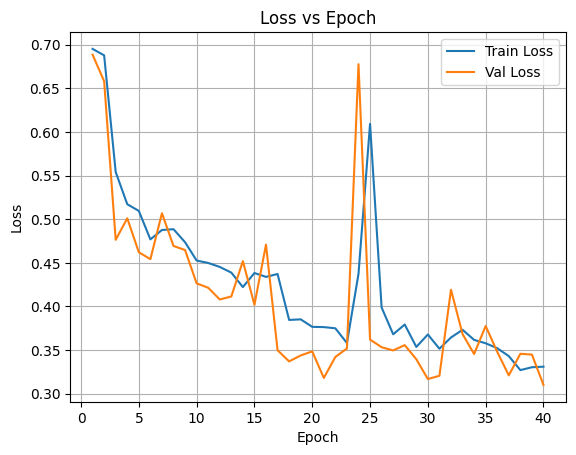

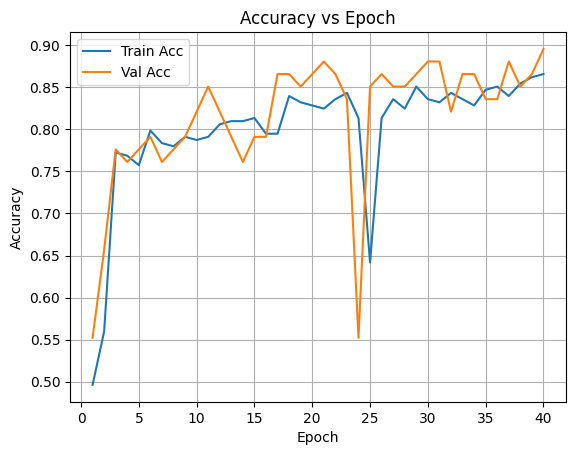

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      1.00      0.81        48
LIP-SYNC DEEPFAKE       1.00      0.55      0.71        49

         accuracy                           0.77        97
        macro avg       0.84      0.78      0.76        97
     weighted avg       0.84      0.77      0.76        97

=== CONFUSION MATRIX ===


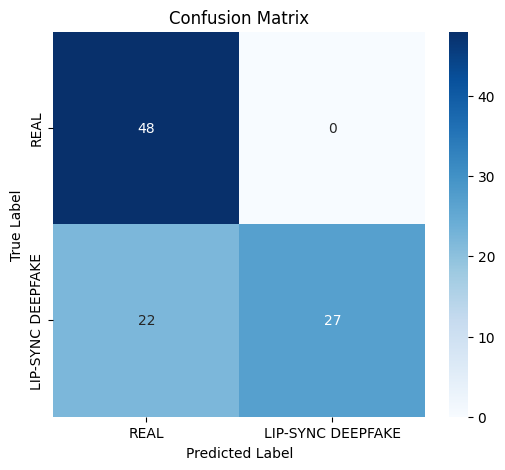

=== ROC AUC ===

📈 AUC Score: 0.8410


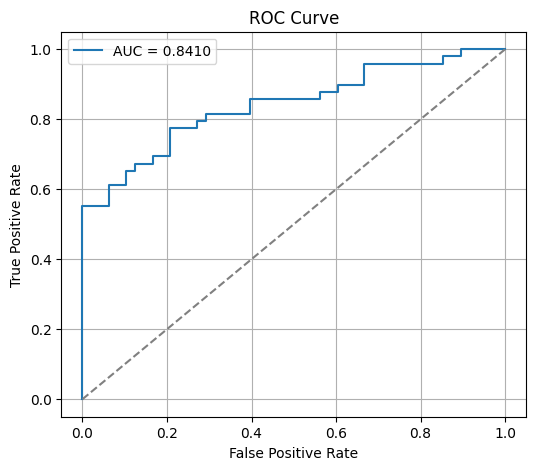

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel5x5_2-BiLSTM_NotPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 18**

**coba kernel 7X7 pada conv (1,64)**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Perbesar kernel menjadi 7x7
            nn.Conv2d(1, 64, kernel_size=(7, 7), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [24]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel7x7_2-BiLSTM_NotPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6955 | Train Acc: 0.4963 | Val Loss: 0.6906 | Val Acc: 0.5522
Epoch [2/40] Train Loss: 0.6933 | Train Acc: 0.4776 | Val Loss: 0.6802 | Val Acc: 0.5522
Epoch [3/40] Train Loss: 0.6278 | Train Acc: 0.6642 | Val Loss: 0.6283 | Val Acc: 0.6716
Epoch [4/40] Train Loss: 0.5088 | Train Acc: 0.7761 | Val Loss: 0.5200 | Val Acc: 0.7910
Epoch [5/40] Train Loss: 0.5660 | Train Acc: 0.7425 | Val Loss: 0.5365 | Val Acc: 0.7761
Epoch [6/40] Train Loss: 0.5361 | Train Acc: 0.7612 | Val Loss: 0.4838 | Val Acc: 0.8060
Epoch [7/40] Train Loss: 0.4961 | Train Acc: 0.7687 | Val Loss: 0.5039 | Val Acc: 0.7910
Epoch [8/40] Train Loss: 0.4945 | Train Acc: 0.7761 | Val Loss: 0.4617 | Val Acc: 0.7910
Epoch [9/40] Train Loss: 0.4742 | Train Acc: 0.7724 | Val Loss: 0.4573 | Val Acc: 0.7761
Epoch [10/40] Train Loss: 0.4748 | Train Acc: 0.7799 | Val Loss: 0.4484 | Val Acc: 0.7910
Epoch [11/40] Train Loss: 0.4697 | Train Acc: 0.7948 | Val Loss: 0.4429 | Val Acc: 0.7910
Epoch [12/40] Train

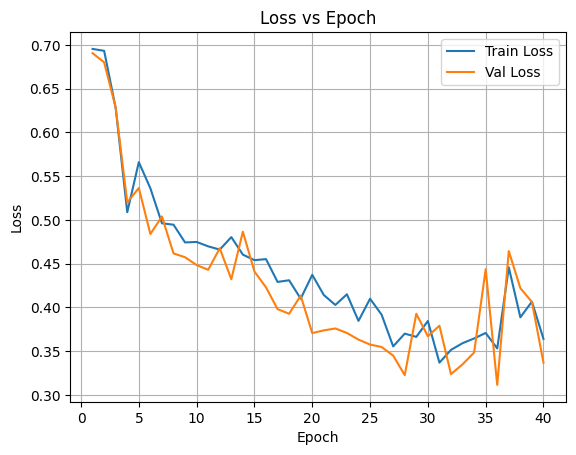

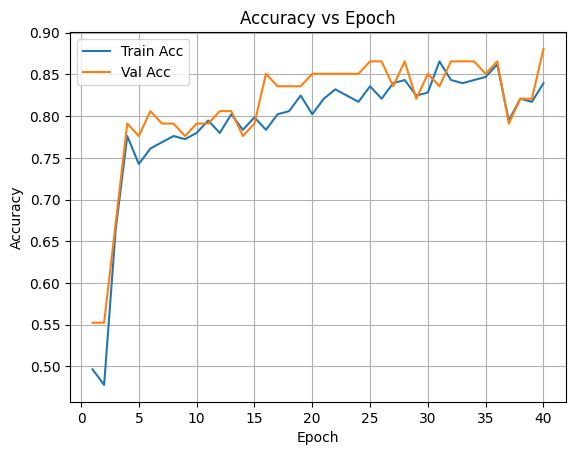

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.65      0.98      0.78        48
LIP-SYNC DEEPFAKE       0.96      0.49      0.65        49

         accuracy                           0.73        97
        macro avg       0.81      0.73      0.72        97
     weighted avg       0.81      0.73      0.72        97

=== CONFUSION MATRIX ===


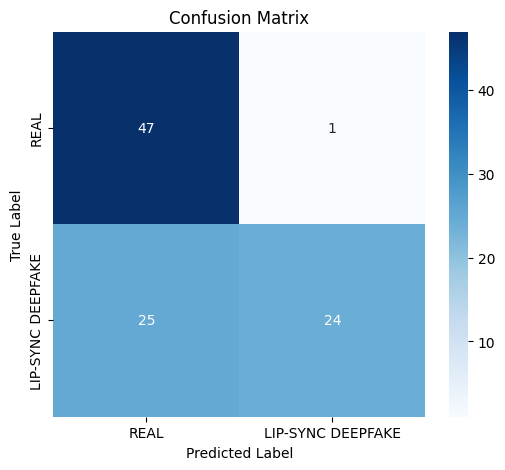

=== ROC AUC ===

📈 AUC Score: 0.8333


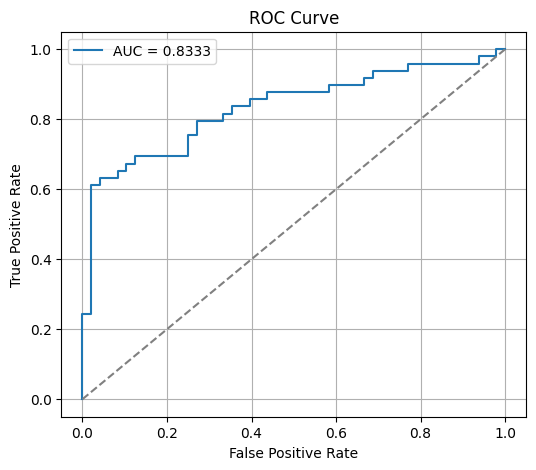

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel7x7_2-BiLSTM_NotPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Modifikasi Jumlah Layer LSTM**

=========================================

**Percobaan 19**

**Coba tambah layer LSTM di BiLSTM jadi 2 tiap BiLSTM**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=2,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 256, 1, 60)
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True, num_layers=2)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        # Tambah num_layers LSTM menjadi 2
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=2, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [29]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Con

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel_2-BiLSTM-NumLayer2_NotPretrained.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6935 | Train Acc: 0.4925 | Val Loss: 0.6960 | Val Acc: 0.4478
Epoch [2/40] Train Loss: 0.6936 | Train Acc: 0.4888 | Val Loss: 0.6945 | Val Acc: 0.4478
Epoch [3/40] Train Loss: 0.6939 | Train Acc: 0.4851 | Val Loss: 0.6932 | Val Acc: 0.4478
Epoch [4/40] Train Loss: 0.6329 | Train Acc: 0.6455 | Val Loss: 0.5773 | Val Acc: 0.7313
Epoch [5/40] Train Loss: 0.5472 | Train Acc: 0.7575 | Val Loss: 0.6039 | Val Acc: 0.7164
Epoch [6/40] Train Loss: 0.5546 | Train Acc: 0.7612 | Val Loss: 0.5564 | Val Acc: 0.7164
Epoch [7/40] Train Loss: 0.5170 | Train Acc: 0.7612 | Val Loss: 0.4746 | Val Acc: 0.7910
Epoch [8/40] Train Loss: 0.4824 | Train Acc: 0.7724 | Val Loss: 0.4514 | Val Acc: 0.8209
Epoch [9/40] Train Loss: 0.5204 | Train Acc: 0.7910 | Val Loss: 0.4494 | Val Acc: 0.8209
Epoch [10/40] Train Loss: 0.4624 | Train Acc: 0.8022 | Val Loss: 0.4338 | Val Acc: 0.8358
Epoch [11/40] Train Loss: 0.4663 | Train Acc: 0.7836 | Val Loss: 0.4326 | Val Acc: 0.8209
Epoch [12/40] Train

In [32]:
print(best_val_loss)
#epoch 25

0.3488650277479371


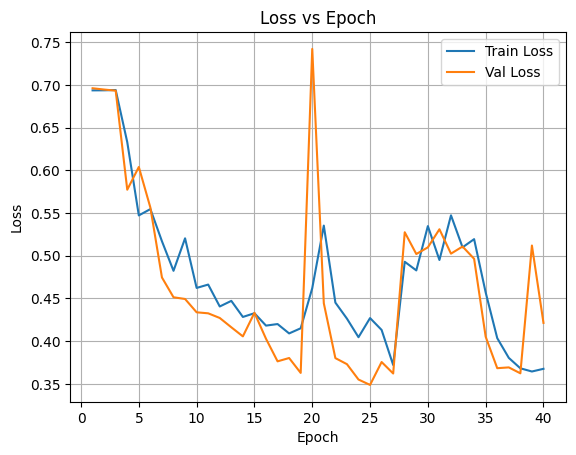

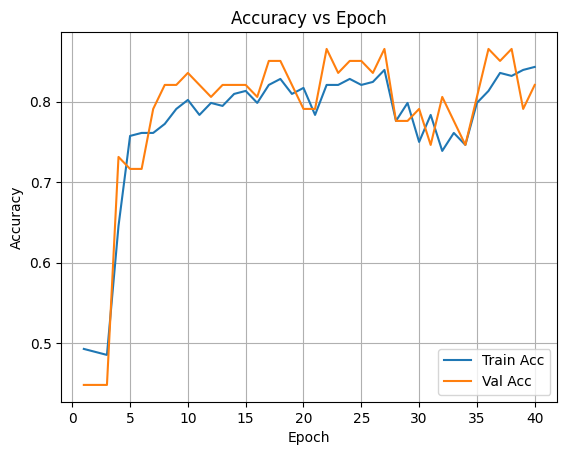

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      0.94      0.79        48
LIP-SYNC DEEPFAKE       0.90      0.57      0.70        49

         accuracy                           0.75        97
        macro avg       0.79      0.75      0.74        97
     weighted avg       0.79      0.75      0.74        97

=== CONFUSION MATRIX ===


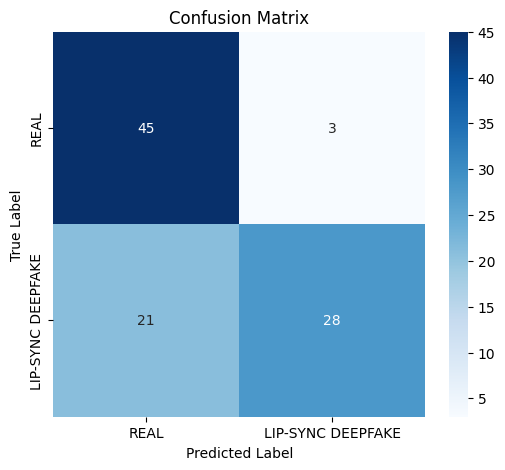

=== ROC AUC ===

📈 AUC Score: 0.7972


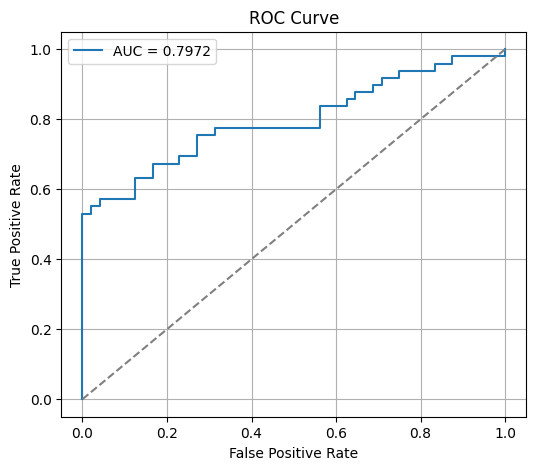

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio-Kernel_2-BiLSTM-NumLayer2_NotPretrained.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

=========================================

**Coba Banyak Epoch**

=========================================

**Percobaan 20**

Bibir (5 Conv Block + 1 BiLSTM) + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM

LR 1e-4

Not Pretrained

Coba 100 Epoch

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1]) 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 1, 64, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 256, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [16]:
# Cek  GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

In [ ]:
num_epochs = 100
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained_100Epoch.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/100] Train Loss: 0.6932 | Train Acc: 0.5187 | Val Loss: 0.6973 | Val Acc: 0.4627
Epoch [2/100] Train Loss: 0.6862 | Train Acc: 0.5000 | Val Loss: 0.6339 | Val Acc: 0.7910
Epoch [3/100] Train Loss: 0.5722 | Train Acc: 0.6903 | Val Loss: 0.5788 | Val Acc: 0.7612
Epoch [4/100] Train Loss: 0.5551 | Train Acc: 0.7425 | Val Loss: 0.4709 | Val Acc: 0.7910
Epoch [5/100] Train Loss: 0.4964 | Train Acc: 0.7537 | Val Loss: 0.4591 | Val Acc: 0.7612
Epoch [6/100] Train Loss: 0.4879 | Train Acc: 0.7612 | Val Loss: 0.4220 | Val Acc: 0.8358
Epoch [7/100] Train Loss: 0.4773 | Train Acc: 0.7799 | Val Loss: 0.4172 | Val Acc: 0.7910
Epoch [8/100] Train Loss: 0.4826 | Train Acc: 0.7836 | Val Loss: 0.4095 | Val Acc: 0.8209
Epoch [9/100] Train Loss: 0.4648 | Train Acc: 0.7873 | Val Loss: 0.4220 | Val Acc: 0.8657
Epoch [10/100] Train Loss: 0.4646 | Train Acc: 0.7799 | Val Loss: 0.3832 | Val Acc: 0.8358
Epoch [11/100] Train Loss: 0.4456 | Train Acc: 0.7948 | Val Loss: 0.4151 | Val Acc: 0.8507
Epoch [1

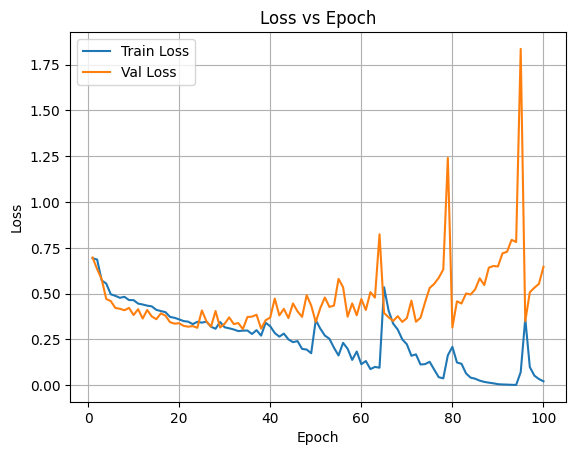

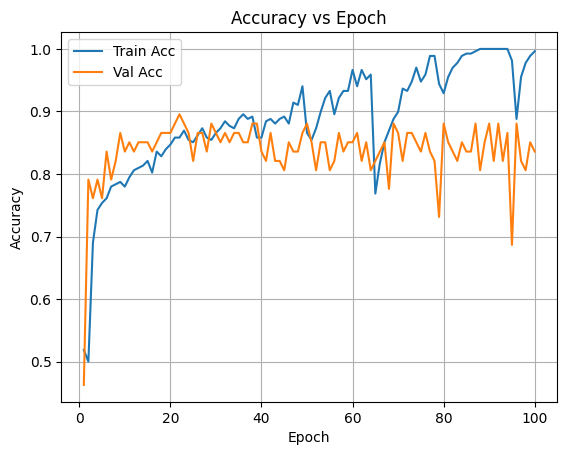

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi Plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      0.96      0.80        48
LIP-SYNC DEEPFAKE       0.93      0.57      0.71        49

         accuracy                           0.76        97
        macro avg       0.81      0.76      0.75        97
     weighted avg       0.81      0.76      0.75        97

=== CONFUSION MATRIX ===


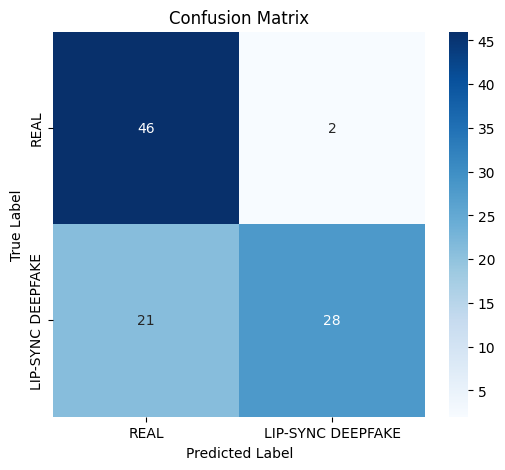

=== ROC AUC ===

📈 AUC Score: 0.8729


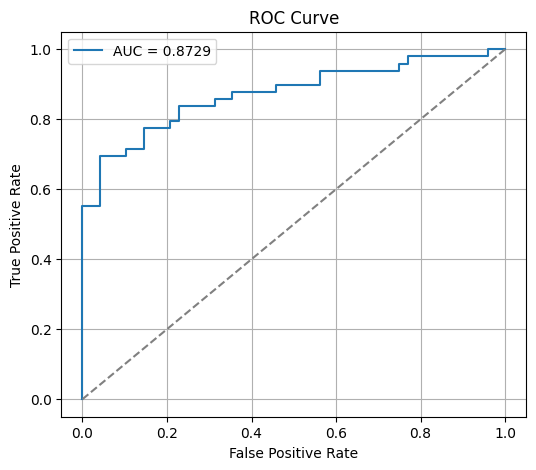

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained_100Epoch.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")  
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
    
        try:
            outputs = model(frames, audio)
            
            probs = torch.softmax(outputs, dim=1)
            probs_class1.extend(probs[:, 1].cpu().numpy())

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            pred_labels.extend(preds)
            true_labels.extend(true)
        except Exception as e:
            continue
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()